**Note:** The numerical data presented in this notebook may not exactly match the figures in the paper due to additional numerical simulations conducted during the process; however, the conclusions remain unchanged. 

Additionally, some parts of the analysis and methods used to generate figures (Fig. 1, 3, and 9) are demonstrated in *Cluster_Analyzer_Demo.ipynb*.


# Imports

In [1]:
import os
import io
import csv
import ast
import pickle
import warnings
import logging
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
from numba import njit, jit
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.special import zeta
from scipy.stats import linregress
import powerlaw

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle, Patch, FancyArrowPatch
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

from IPython.display import Image, display, clear_output

# Configure warnings and logging
warnings.simplefilter("ignore", UserWarning)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
np.seterr(over='ignore', invalid='ignore')

# Set a plotting style
plt.style.use('bmh')

# Define the data folder
Folder = Path("./FigureData")

# FIG. 2: Asymptotic Quantities in the Logistic GOL

**Dataset Explanation:**

- **lambda**: The control parameter in the logistic Game of Life.
- **mean_M**: The asymptotic average activity order parameter, defined as  
  $$ A_t := 1 - \frac{1}{N^2}\sum_j \delta( s^j_t, s^j_{t-\bar{t}} ), $$  
  which measures the fraction of sites that change state over a time lag $\bar{t}$.
- **avg_max_cluster_size**: The average size of the largest cluster, normalized by the system size ($N^2$), i.e.,  
  $$ \frac{\langle S_1 \rangle}{N^2}. $$
- **chi**: The susceptibility, defined as the fluctuation of the order parameter,  
  $$ \langle \chi \rangle := \langle A^2 \rangle - \langle A \rangle^2, $$  
  which quantifies how uniformly the activity is distributed across the lattice.

**Plot Details:**

- **Panel (a):**  
  - The left y-axis displays the average order parameter $\langle A \rangle$ (plotted in SteelBlue).
  - The right y-axis shows the normalized average max cluster size $\langle S_1 \rangle/N^2$ (plotted in FireBrick).
  - Vertical dashed lines are drawn at critical values $\lambda_P = 0.8605$ and $\lambda_A = 0.875$, marking key phase transitions.
  - This panel illustrates how, as $\lambda$ increases, the system undergoes a transition from an inactive phase (low activity, small $\langle S_1 \rangle/N^2$) to an active phase (higher activity and a spanning cluster).

- **Panel (b):**  
  - The susceptibility $\langle \chi \rangle/N^2$ is plotted versus $\lambda$, with the same critical points indicated.
  - The susceptibility peaks near $\lambda_A$, highlighting a strong spatial inhomogeneity in activity as the system transitions between phases.

**Key Observations:**

- For $\lambda < \lambda_A$, the system exhibits nearly zero activity ($\langle A \rangle \simeq 0$), indicating an inactive phase dominated by quiescent states.
- At $\lambda = \lambda_A$, a sudden increase in $\langle A \rangle$ is observed, accompanied by a maximum in $\langle \chi \rangle$, signaling the onset of an active phase.
- Near $\lambda_P$, the normalized size of the largest cluster undergoes a sharp decrease, indicating a percolation transition where the vacuum (quiescent) cluster loses its spanning character.
- These changes reflect two distinct phase transitions: one at $\lambda_A$, marking the inactive-active transition, and another at $\lambda_P$, indicating the breakup of the spanning vacuum cluster.

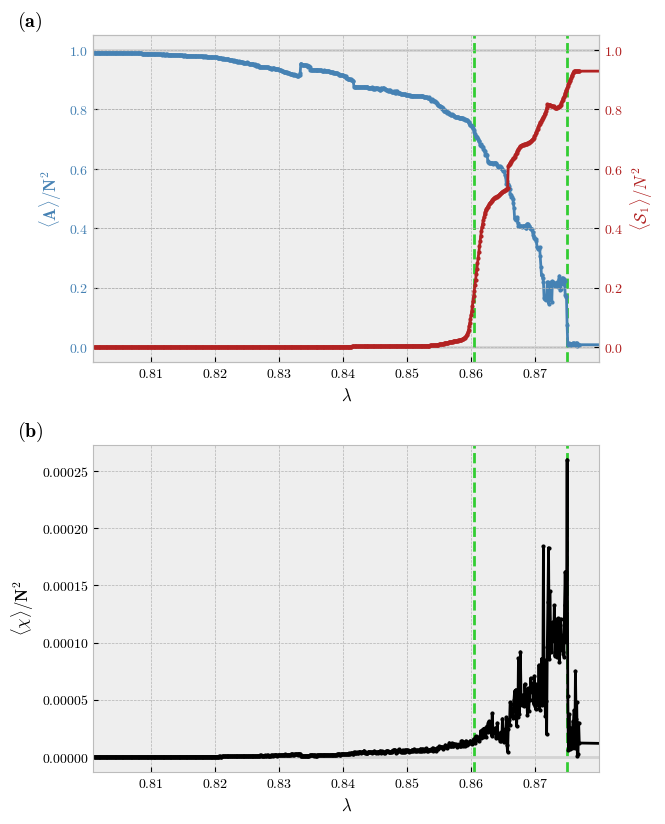

In [2]:
# Load data
df_plot = pd.read_csv(Folder / "Fig2_data.csv")

# Define plot parameters and colors (same as in your original code)
SteelBlue = 'steelblue'
FireBrick = 'firebrick'
LimeGreen = 'limegreen'
markersize_global = 2
subcaption = ['(a)', '(b)']

fig_width = 2*(3+3/8)
fig, axs = plt.subplots(2, figsize=(fig_width, fig_width*2/1.618), layout='constrained')

# --------------------------------------------------------------------------------------------
# Panel (a): Plot Average Order Parameter and Normalized Max Cluster Size vs. Lambda

axs[0].set_xlim(0.801, 0.88)
axs[0].axhline(0, color='lightgray')
axs[0].axhline(1, color='lightgray')
# Critical lambda values (adjust lambda_1 and lambda_2 as appropriate)
lambda_1 = 0.8605
lambda_2 = 0.875
axs[0].axvline(lambda_1, color=LimeGreen, linewidth=2, linestyle='--')
axs[0].axvline(lambda_2, color=LimeGreen, linewidth=2, linestyle='--')

# Plot average order parameter on left y-axis
axs[0].plot(df_plot["lambda"], df_plot["mean_M"],
            'o-', color=SteelBlue, markersize=markersize_global, label='Average Order Parameter')
axs[0].set_xlabel('$\\bf{\\lambda}$')
axs[0].tick_params(axis='y', labelcolor=SteelBlue)
axs[0].set_ylim(-0.05, 1.05)

# Create twin y-axis for normalized average max cluster size
ax2 = axs[0].twinx()
grid_size = 1024*1024  # system grid size
ax2.set_xlim(0.801, 0.88)
ax2.plot(df_plot["lambda"], (1/grid_size)*df_plot["avg_max_cluster_size"], 'o-', color=FireBrick, 
         markersize=markersize_global, label='Average Max Cluster Size')
axs[0].set_ylabel('$\\bf{\\langle A \\rangle / N^2}$', color=SteelBlue)
ax2.set_ylabel('$\\langle \\mathcal{S}_{1} \\rangle / N^2$', color=FireBrick)
ax2.tick_params(axis='y', labelcolor=FireBrick)
ax2.set_ylim(-0.05, 1.05)

# Format x and y tick labels for axs[0]
xticks = axs[0].get_xticks()[1:-1]
axs[0].set_xticks(xticks)
labels = ['$\\bf{' + item.get_text() + '}$' for item in axs[0].get_xticklabels()]
axs[0].set_xticklabels(labels)
yticks = axs[0].get_yticks()[1:-1]
axs[0].set_yticks(yticks)
labels = ['$\\bf{' + item.get_text() + '}$' for item in axs[0].get_yticklabels()]
axs[0].set_yticklabels(labels)
yticks2 = ax2.get_yticks()[1:-1]
ax2.set_yticks(yticks2)
labels = ['$\\bf{' + item.get_text() + '}$' for item in ax2.get_yticklabels()]
ax2.set_yticklabels(labels)

axs[0].set_title(f'$\\bf{{ {subcaption[0]} }}$', x=-1/8, fontweight='bold')

# --------------------------------------------------------------------------------------------
# Panel (b): Plot Susceptibility vs. Lambda

axs[1].axvline(lambda_1, color=LimeGreen, linewidth=2, linestyle='--')
axs[1].axvline(lambda_2, color=LimeGreen, linewidth=2, linestyle='--')
axs[1].axhline(0, color='lightgray')
axs[1].plot(df_plot["lambda"], df_plot["chi"], marker='o', markersize=markersize_global, 
            linestyle='-', color='black')
axs[1].set_xlabel('$\\bf{\\lambda}$')
axs[1].set_ylabel('$\\bf{\\langle \\chi \\rangle / N^2}$')
axs[1].set_xlim(0.801, 0.88)
xticks = axs[1].get_xticks()[1:-1]
axs[1].set_xticks(xticks)
labels = ['$\\bf{' + item.get_text() + '}$' for item in axs[1].get_xticklabels()]
axs[1].set_xticklabels(labels)
yticks = axs[1].get_yticks()[1:-1]
axs[1].set_yticks(yticks)
labels = ['$\\bf{' + item.get_text() + '}$' for item in axs[1].get_yticklabels()]
axs[1].set_yticklabels(labels)
axs[1].set_title(f'$\\bf{{ {subcaption[1]} }}$', x=-1/8, fontweight='bold')

plt.tight_layout()
plt.show()


# Fig 4 (Panel a):

**Dataset Explanation:**

- **State Matrix:**  
  Each top-panel image displays a snapshot of the asymptotic state of the logistic Game of Life (GOL). The state matrix is rendered as a binary image, where one color (typically white) indicates quiescent (inactive) sites and the other indicates active sites.

- **λ (lambda):**  
  The snapshots are taken at selected λ values within the range [0.850, 0.875]. These values are chosen to illustrate the evolution of the system’s asymptotic state as the control parameter λ is varied.

- **Index:**  
  For each λ value, a specific index is used to select a representative state from the simulation.

**Plot Details (Panel a):**

- The top panels show the spatial distribution of states in the lattice at different λ values.
- As λ increases from 0.850 to 0.875, the snapshots reveal changes in the pattern of activity:
  - At lower λ (e.g., around 0.850), the lattice is mostly quiescent with only small, scattered active regions.
  - As λ increases, the state matrices exhibit more complex patterns, reflecting an increased level of activity and a transition in the dynamical regime.

**Key Observations:**
 
- **At Low λ (≈ 0.850):**  
  The lattice is mostly inactive with small clusters of activity, suggesting uniform quiescence.
- **As λ Increases:**  
  The overall state becomes more heterogeneous, and clusters start to grow in size. Near the critical point λ_P (≈ 0.86055), the second largest cluster reaches a maximum, and the largest zero-state cluster begins to percolate.
- **For λ > λ_P (up to 0.875):**  
  The largest cluster dramatically increases in size—spanning a significant fraction of the lattice—while the sizes of the lower-ranked clusters decrease.  
- These trends, together with further analyses of capacity dimensions and scaling behavior (detailed in other panels of FIG. 4), reveal a percolation transition hidden in the logistic GOL, where the morphology of clusters changes from chain-like and sparse to area-like and dense.

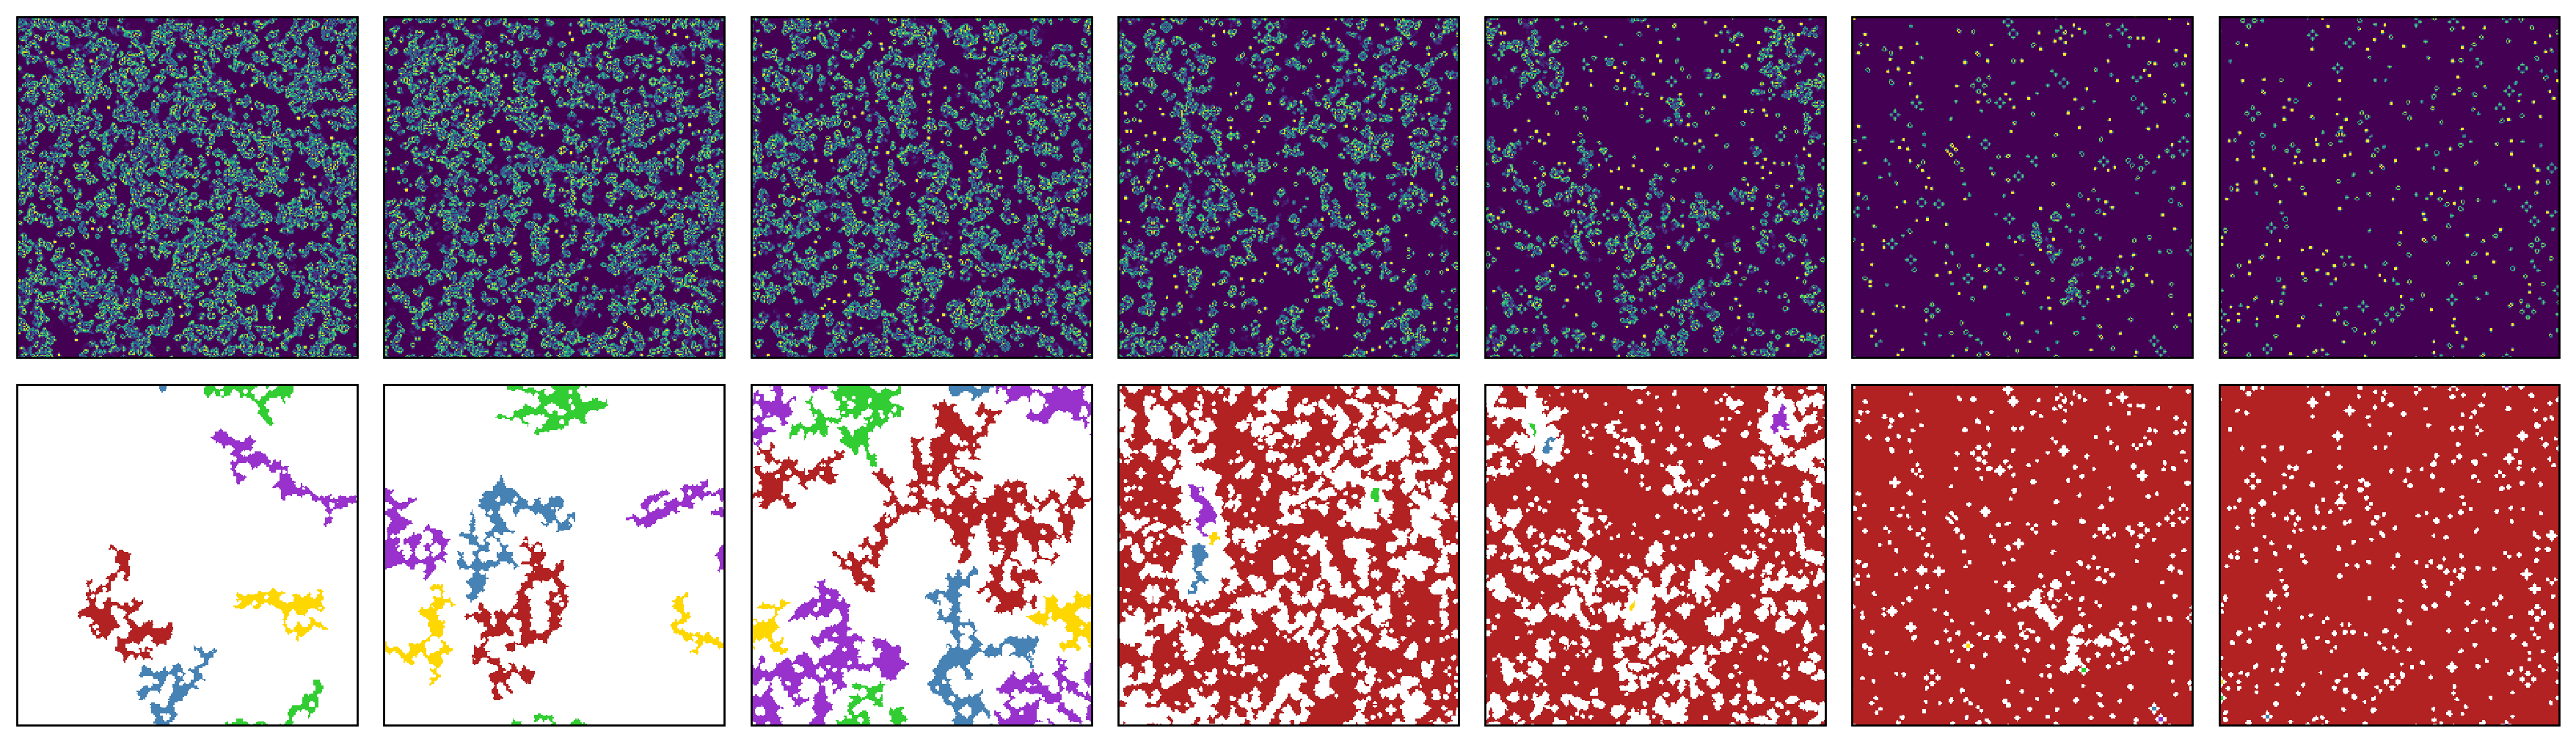

In [3]:
# Load data
with open(Folder / "Fig3a_cluster_image_list", 'rb') as dbfile:
    cluster_image_list = pickle.load(dbfile)

with open(Folder / "Fig3a_state_matrix_list", 'rb') as dbfile:
    state_matrix_list = pickle.load(dbfile)

lamdas = [0.85, 0.855, 0.86, 0.865, 0.87, 0.875, 0.88]
indexs = [9, 3, 7, 1, 4, 4, 6]

# Define the custom colormap
cmap = ListedColormap([[1, 1, 1], [0.698, 0.133, 0.133], [0.6, 0.196, 0.8], 
                       [0.275, 0.51, 0.706], [0.196, 0.804, 0.196], [1, 0.843, 0]])

# Set up the figure with 2 rows and columns equal to the number of lambda points
fig, axes = plt.subplots(2, len(lamdas), figsize=(5 * len(lamdas), 10), constrained_layout=True)
fig.subplots_adjust(wspace=0, hspace=0)  # No space between subplots

# Iterate over each lambda and populate the subplots
for i, (lamda, idx) in enumerate(zip(lamdas, indexs)):
    cluster_image1 = cluster_image_list[i][idx]
    state_matrix1 = state_matrix_list[i][idx]

    # Top row: state_matrix images (binary colormap)
    ax3 = axes[0, i]
    im1 = ax3.pcolor(state_matrix1)
    ax3.axis('equal')
    ax3.axis('off')
    ax3.add_patch(Rectangle((ax3.get_xlim()[0], ax3.get_ylim()[0]),
                            ax3.get_xlim()[1] - ax3.get_xlim()[0],
                            ax3.get_ylim()[1] - ax3.get_ylim()[0],
                            fill=False, edgecolor='black', lw=2))

    # Bottom row: cluster_image images (custom colormap)
    ax0 = axes[1, i]
    pcol = ax0.pcolor(cluster_image1, cmap=cmap)
    ax0.axis('equal')
    ax0.axis('off')
    ax0.add_patch(Rectangle((ax0.get_xlim()[0], ax0.get_ylim()[0]),
                            ax0.get_xlim()[1] - ax0.get_xlim()[0],
                            ax0.get_ylim()[1] - ax0.get_ylim()[0],
                            fill=False, edgecolor='black', lw=2))
  
plt.show() 


# FIG. 4 (Panel b-c-d):  

**Dataset Explanation:**

- **From Means:**  
  - **lambda:** The control parameter value.
  - **max_cluster_size, second_max_cluster_size, third_max_cluster_size, fourth_max_cluster_size, fifth_max_cluster_size:**  
    The sizes of the largest five clusters, averaged over ensemble and time. These quantities are later normalized by the system grid size (here, 1024×1024).
  - **largest_i_dimension:** The capacity (fractal) dimension of the i-th largest cluster.
  - **largest_i_dimension_std:** The standard deviation (σ_D) of the capacity dimension for the i-th largest cluster.

**Plot Details:**

- **Panel (b):**  
  Plots the normalized sizes of the largest clusters (i.e. $\langle S_i \rangle / N^2$ for $i=2$ to $5$) against $ \lambda $.  
  - When $\lambda < \lambda_P$, the curves differ only by a scaling factor; the inset shows the logarithmic evolution of cluster sizes, with the second largest cluster peaking at $\lambda = \lambda_P$.  
  - For $\lambda > \lambda_P$, the largest cluster increases significantly, while the sizes of the lower-ranked clusters drop.

- **Panel (c):**  
  Displays the capacity dimensions $\langle D \rangle$ of the largest clusters as functions of $\lambda$.  
  - As $\lambda$ increases toward $\lambda_P$ from below, the capacity dimensions converge (e.g. $d_c \approx 1.610$), suggesting scale invariance in cluster shape.  
  - For $\lambda > \lambda_P$, the largest cluster’s capacity dimension increases, whereas those of the smaller clusters decrease.

- **Panel (d):**  
  Shows the standard deviations $\sigma_D$ of the capacity dimensions versus $\lambda$.  
  - The variability of the capacity dimensions decreases and reaches a minimum as $\lambda$ approaches $\lambda_P$ from below.  
  - For $\lambda > \lambda_P$, $\sigma_D$ remains low for the largest cluster but increases for the other clusters, indicating that the largest cluster’s shape becomes more uniform while the others become more variable.

**Key Observations:**

- **Cluster Size Trends (Panel b):**  
  - At $\lambda \simeq 0.85$, all clusters are relatively small compared to the lattice.  
  - As $\lambda$ increases toward $\lambda_P$, the size of every cluster grows, with the second largest cluster reaching its maximum at $\lambda = \lambda_P$.  
  - For $\lambda > \lambda_P$, the largest cluster grows dramatically (signaling percolation), while the sizes of lower-ranked clusters drop significantly.

- **Capacity Dimension Behavior (Panel c):**  
  - Near $\lambda_P$, the capacity dimensions of all clusters converge to nearly identical values, indicating that the clusters become scale-invariant in shape.  
  - Beyond $\lambda_P$, the largest cluster’s capacity dimension increases (suggesting a denser, area-like structure), while those of the smaller clusters decrease (indicating more chain-like, sparse configurations).

- **Variability of Cluster Shapes (Panel d):**  
  - The standard deviation $\sigma_D$ of the capacity dimensions decreases for all clusters as $\lambda$ approaches $\lambda_P$, reflecting a stabilization in cluster shape and scale invariance as all samples becomes equivalent.  
  - For $\lambda > \lambda_P$, $\sigma_D$ remains low for the largest cluster but increases for the other clusters, demonstrating that the largest cluster maintains a consistent shape while the smaller clusters become more irregular.

These observations collectively reveal that, as $\lambda$ is tuned, the logistic GOL undergoes a percolation transition. The evolution in cluster sizes, capacity dimensions, and their variability provides clear evidence of changes in the geometric properties of clusters at criticality.

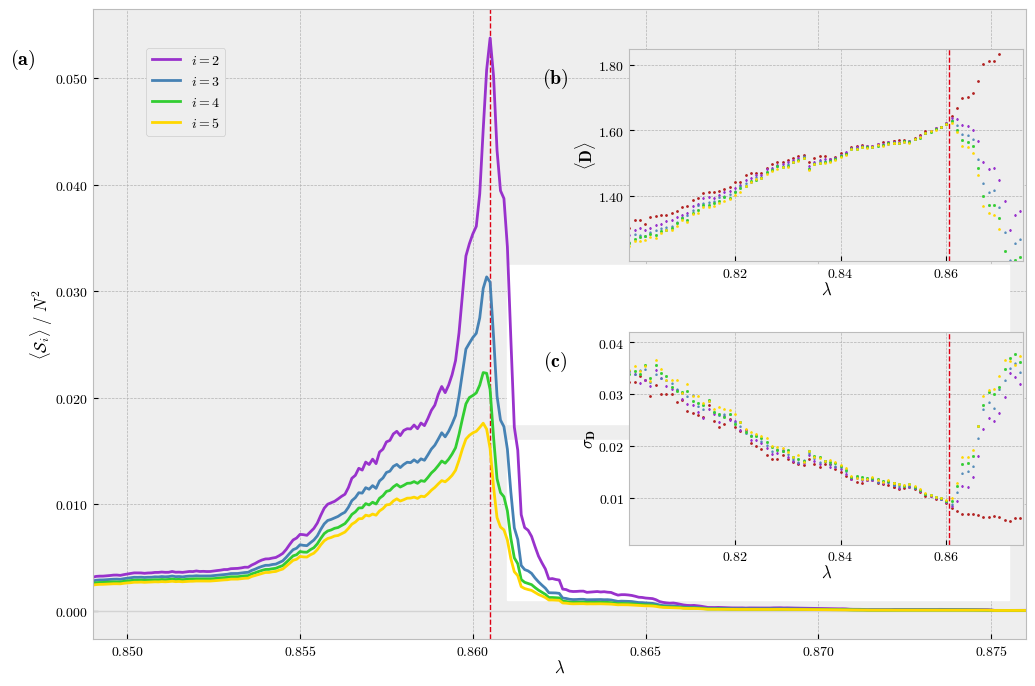

In [4]:
# Load data
df_plot = pd.read_csv(Folder / "Fig4b_4c_4d_data.csv")

# Define plot parameters and colors
width = 3*(3+3/8)
height = width*2/3
subcaption = ['(a)', '(b)', '(c)']
markers = ['o', 'd', '^', 's', 'p']
# Define custom colors (make sure these are consistent with your desired color scheme)
FireBrick = 'firebrick'
DarkOrchid = 'darkorchid'
SteelBlue = 'steelblue'
LimeGreen = 'limegreen'
Gold = 'gold'
colors = [FireBrick, DarkOrchid, SteelBlue, LimeGreen, Gold]

grid_size = 1000*1000  # or 1024*1024 if appropriate
markersize_global = 0
linewidth_global = 2

# Create the main figure
fig = plt.figure(figsize=(width, height), layout="constrained")

inset_scale = 0.422

# Main axes for the normalized cluster sizes and order parameter
ax0 = fig.add_subplot(1,1,1)
ax0.axhline(y=0, color='lightgray', linestyle='-', linewidth=1)
ax0.grid(axis='x', zorder=0)

# Add white patches to hide specific areas (if needed)
ax0.add_patch(Rectangle((0.861,0.001), 0.0145, 0.015, facecolor='white', edgecolor='white', lw=1, zorder=2))
ax0.add_patch(Rectangle((0.861,0.0175), 0.0145, 0.015, facecolor='white', edgecolor='white', lw=1, zorder=2))

# Draw vertical critical line
ax0.axvline(x=0.8605, color=LimeGreen, linestyle='--', linewidth=1, c='#DE0014')

# Plot cluster sizes (for clusters ranked 2 to 5) normalized by grid size
# (Assuming "Means" columns are available in the loaded CSV)
# Here, the i = 1 curve (largest cluster) is commented out
ax0.plot(df_plot["lambda"], (1/grid_size)*df_plot["second_max_cluster_size"],
         marker=markers[1], color=colors[1], markersize=markersize_global, linewidth=linewidth_global, label='$i = 2$')
ax0.plot(df_plot["lambda"], (1/grid_size)*df_plot["third_max_cluster_size"],
         marker=markers[2], color=colors[2], markersize=markersize_global, linewidth=linewidth_global, label='$i = 3$')
ax0.plot(df_plot["lambda"], (1/grid_size)*df_plot["fourth_max_cluster_size"],
         marker=markers[3], color=colors[3], markersize=markersize_global, linewidth=linewidth_global, label='$i = 4$')
ax0.plot(df_plot["lambda"], (1/grid_size)*df_plot["fifth_max_cluster_size"],
         marker=markers[4], color=colors[4], markersize=markersize_global, linewidth=linewidth_global, label='$i = 5$')

# Set axis limits
ax0.set_xlim(0.849, 0.876)
# ax0.set_ylim(-0.001, 0.035)  # Uncomment and adjust if needed

# Label axes
ax0.set_xlabel('$\\bf \\lambda$', labelpad=0)
ax0.set_ylabel('$\\langle \\mathcal{S}_{i} \\rangle \\; / \\; N^2$', labelpad=0)

# Format x-ticks for ax0
xticks = ax0.get_xticks()
ax0.set_xticks(xticks[1:-1])
labels = ['$\\bf{{ {0} }}$'.format(item.get_text()) for item in ax0.get_xticklabels()]
ax0.set_xticklabels(labels)

# Format y-ticks for ax0
yticks = ax0.get_yticks()
ax0.set_yticks(yticks[1:-1])
labels = ['$\\bf{{ {0:.3f} }}$'.format(float(item.get_text())) for item in ax0.get_yticklabels()]
ax0.set_yticklabels(labels)

ax0.set_title('$\\bf{{ {0} }}$'.format(subcaption[0]), x=-1.2/16, y=0.9, fontweight='bold')

# --------------------------------------------------------------------------------------------
# Inset Axes 1: Capacity Dimensions of Largest Clusters
ax1 = ax0.inset_axes((0.575, 0.600, inset_scale, inset_scale/1.25))
ax1.axhline(y=1, color='lightgray', linestyle='-', linewidth=1)
ax1.axhline(y=2, color='lightgray', linestyle='-', linewidth=1)
ax1.axvline(x=0.8605, color=LimeGreen, linestyle='--', linewidth=1, c='#DE0014')

# Plot capacity dimensions for each of the 5 largest clusters from df_dimensions columns
for i in range(1, 6):
    dimension_key = f'largest_{i}_dimension'
    if dimension_key in df_plot.columns:
        # Sort by lambda for consistent plotting
        idx = np.argsort(df_plot['lambda'].to_numpy())
        lambda_sorted = np.take_along_axis(df_plot['lambda'].to_numpy(), idx, axis=0)
        dimension_sorted = np.take_along_axis(df_plot[dimension_key].to_numpy(), idx, axis=0)
        ax1.plot(lambda_sorted, dimension_sorted, label='$S_{{{}}}$'.format(i),
                 marker=markers[i-1], color=colors[i-1], markersize=1, linewidth=0)
ax1.set_xlim(0.8, 0.8745)
ax1.set_ylim(1.2, 1.85)
ax1.set_xlabel('$\\bf \\lambda$', labelpad=0)
ax1.set_ylabel('$\\bf \\langle D \\rangle$', labelpad=0)
xticks = ax1.get_xticks()
ax1.set_xticks(xticks[1:-1])
labels = ['$\\bf{{ {0} }}$'.format(item.get_text()) for item in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)
yticks = ax1.get_yticks()
ax1.set_yticks(yticks[1:-1])
labels = ['$\\bf{{ {0:.2f} }}$'.format(float(item.get_text())) for item in ax1.get_yticklabels()]
ax1.set_yticklabels(labels)
ax1.set_title('$\\bf{{ {0} }}$'.format(subcaption[1]), x=-3/16, y=0.8, fontweight='bold')

# --------------------------------------------------------------------------------------------
# Inset Axes 2: Standard Deviations of Capacity Dimensions
ax2 = ax0.inset_axes((0.575, 0.15, inset_scale, inset_scale/1.25))
ax2.axhline(y=0, color='lightgray', linestyle='-', linewidth=1)
ax2.axhline(y=2, color='lightgray', linestyle='-', linewidth=1)
ax2.axvline(x=0.8605, color=LimeGreen, linestyle='--', linewidth=1, c='#DE0014')

for i in range(1, 6):
    dimension_key = f'largest_{i}_dimension'
    std_key = f'largest_{i}_dimension_std'
    if dimension_key in df_plot.columns and std_key in df_plot.columns:
        idx = np.argsort(df_plot['lambda'].to_numpy())
        lambda_sorted = np.take_along_axis(df_plot['lambda'].to_numpy(), idx, axis=0)
        std_sorted = np.take_along_axis(df_plot[std_key].to_numpy(), idx, axis=0)
        ax2.plot(lambda_sorted, std_sorted, marker=markers[i-1], color=colors[i-1],
                 markersize=1, linewidth=0)
ax2.set_xlim(0.8, 0.8745)
ax2.set_ylim(0.001, 0.042)
ax2.set_xlabel('$\\bf \\lambda$', labelpad=0)
ax2.set_ylabel('$\\bf \\sigma_D$', labelpad=0)
xticks = ax2.get_xticks()
ax2.set_xticks(xticks[1:-1])
labels = ['$\\bf{{ {0} }}$'.format(item.get_text()) for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels)
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[1:-1])
labels = ['$\\bf{{ {0:.2f} }}$'.format(float(item.get_text())) for item in ax2.get_yticklabels()]
ax2.set_yticklabels(labels)
ax2.set_title('$\\bf{{ {0} }}$'.format(subcaption[2]), x=-3/16, y=0.8, fontweight='bold')

# --------------------------------------------------------------------------------------------
ax0.legend(framealpha=1, loc='upper left', bbox_to_anchor=(0.05, 0.95))
 
plt.show()


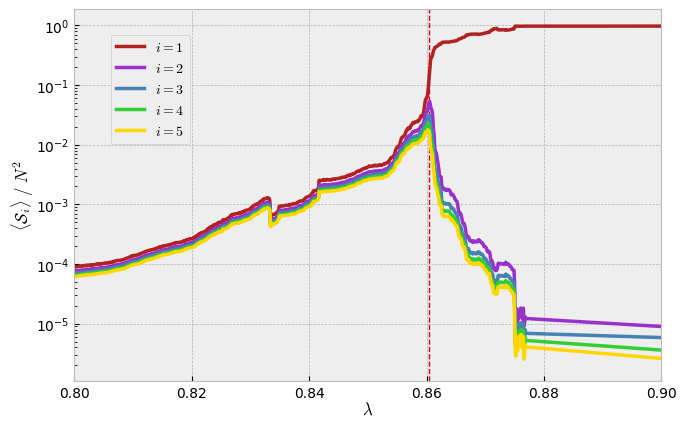

In [5]:
# Define plot parameters and colors
width = 2*(3+3/8)
golden = (1 + 5**0.5)/2
height = width/golden
grid_size = 1000*1000  # Normalization constant (N^2)
markersize_global = 0   # Markers are hidden (markersize=0) to display only lines
linewidth_global = 2.5

subcaption = [""]
markers = ['o', 'd', '^', 's', 'p']

# Define custom colors for each cluster rank
FireBrick = [0.698, 0.133, 0.133]
DarkOrchid = [0.6, 0.196, 0.8]
SteelBlue = [0.275, 0.51, 0.706]
LimeGreen = [0.196, 0.804, 0.196]
Gold       = [1, 0.843, 0]
colors = [FireBrick, DarkOrchid, SteelBlue, LimeGreen, Gold]

# Create the figure and main axes
fig = plt.figure(figsize=(width, height), layout="constrained")
ax0 = fig.add_subplot(1,1,1)

# Draw a vertical dashed line at the critical λ value (0.8605)
ax0.axvline(x=0.8605, color=SteelBlue, linestyle='--', linewidth=1, c='#DE0014')

# Plot normalized cluster sizes from the CSV file
ax0.plot(df_plot["lambda"], (1/grid_size)*df_plot["max_cluster_size"], 
         marker=markers[0], color=colors[0], markersize=markersize_global, linewidth=linewidth_global, label='$i = 1$')
ax0.plot(df_plot["lambda"], (1/grid_size)*df_plot["second_max_cluster_size"], 
         marker=markers[1], color=colors[1], markersize=markersize_global, linewidth=linewidth_global, label='$i = 2$')
ax0.plot(df_plot["lambda"], (1/grid_size)*df_plot["third_max_cluster_size"], 
         marker=markers[2], color=colors[2], markersize=markersize_global, linewidth=linewidth_global, label='$i = 3$')
ax0.plot(df_plot["lambda"], (1/grid_size)*df_plot["fourth_max_cluster_size"], 
         marker=markers[3], color=colors[3], markersize=markersize_global, linewidth=linewidth_global, label='$i = 4$')
ax0.plot(df_plot["lambda"], (1/grid_size)*df_plot["fifth_max_cluster_size"], 
         marker=markers[4], color=colors[4], markersize=markersize_global, linewidth=linewidth_global, label='$i = 5$')

# Set x-axis limits and set y-axis to logarithmic scale
ax0.set_xlim(0.8, 0.9)
ax0.set_yscale('log')

# Label the axes
ax0.set_xlabel('$\\bf \\lambda$', labelpad=0)
ax0.set_ylabel('$\\langle \\mathcal{S}_{i} \\rangle \\; / \\; N^2$', labelpad=0)
 
# Set plot title
ax0.set_title('$\\bf{{ {0} }}$'.format(subcaption[0]), x=-1.2/16, y=0.9, fontweight='bold')

# Add legend to the plot
ax0.legend(framealpha=1, loc='upper left', bbox_to_anchor=(0.05, 0.95))
 
plt.show()


# Fig 4 (Panel e) & Fig 11:

**Dataset Explanation:**

- **lambda**: The original $\lambda$ value from the simulation.
- **lambda_group**: The representative $\lambda$ value for the group (e.g. 0.855, 0.86055, or 0.865).
- **Size**: The system size $N$.
- **max_cluster_size**, **second_max_cluster_size**, **third_max_cluster_size**, **fourth_max_cluster_size**, **fifth_max_cluster_size**: The measured cluster sizes.

**Plot Details:**

- Group the data by system size ($N$) and compute the mean cluster sizes.
- Plot the data for each of the five cluster size columns (from the largest to the fifth largest) as scattered points.
- Fit a curve to the data using a suitable fit function:
  - For $\lambda = 0.855$, a logarithmic fit is used.
  - For $\lambda = 0.86055$ and $\lambda = 0.865$, a power-law fit is applied.
- Display the fitted curves as dashed lines.
- Format the axes in logarithmic scale (for $x$ and, where applicable, $y$ - in critical and supercritcal regime-).
- Add legends that indicate the scaling behavior (with fit parameters) for each cluster (i.e. $i=1$ to 5).

Scaling behavior of the largest cluster with lattice size ($N$) around $\lambda_P$. In the *subcritical* regime ($\lambda < \lambda_P$, left), cluster sizes $\langle S_i(N) \rangle$ follow a logarithmic trend. Around the critical point ($\lambda = \lambda_P$, middle), the clusters scale as power laws, where the exponent of the largest cluster defines the fractal dimension $d_f$. In the *supercritical* regime ($\lambda > \lambda_P$, right), the largest cluster $\langle S_1 \rangle$ scales with the system’s dimension, spanning the lattice. The associated fits are shown with dashed lines. 
  
**Key observations:**
- **Subcritical regime ($\lambda < \lambda_P$):** Cluster sizes follow a logarithmic scaling law.
- **Critical regime ($\lambda \approx \lambda_P$):** Cluster sizes exhibit power-law scaling, highlighting the fractal nature of the clusters.
- **Supercritical regime ($\lambda > \lambda_P$):** The largest cluster scales nearly as $N^2$.

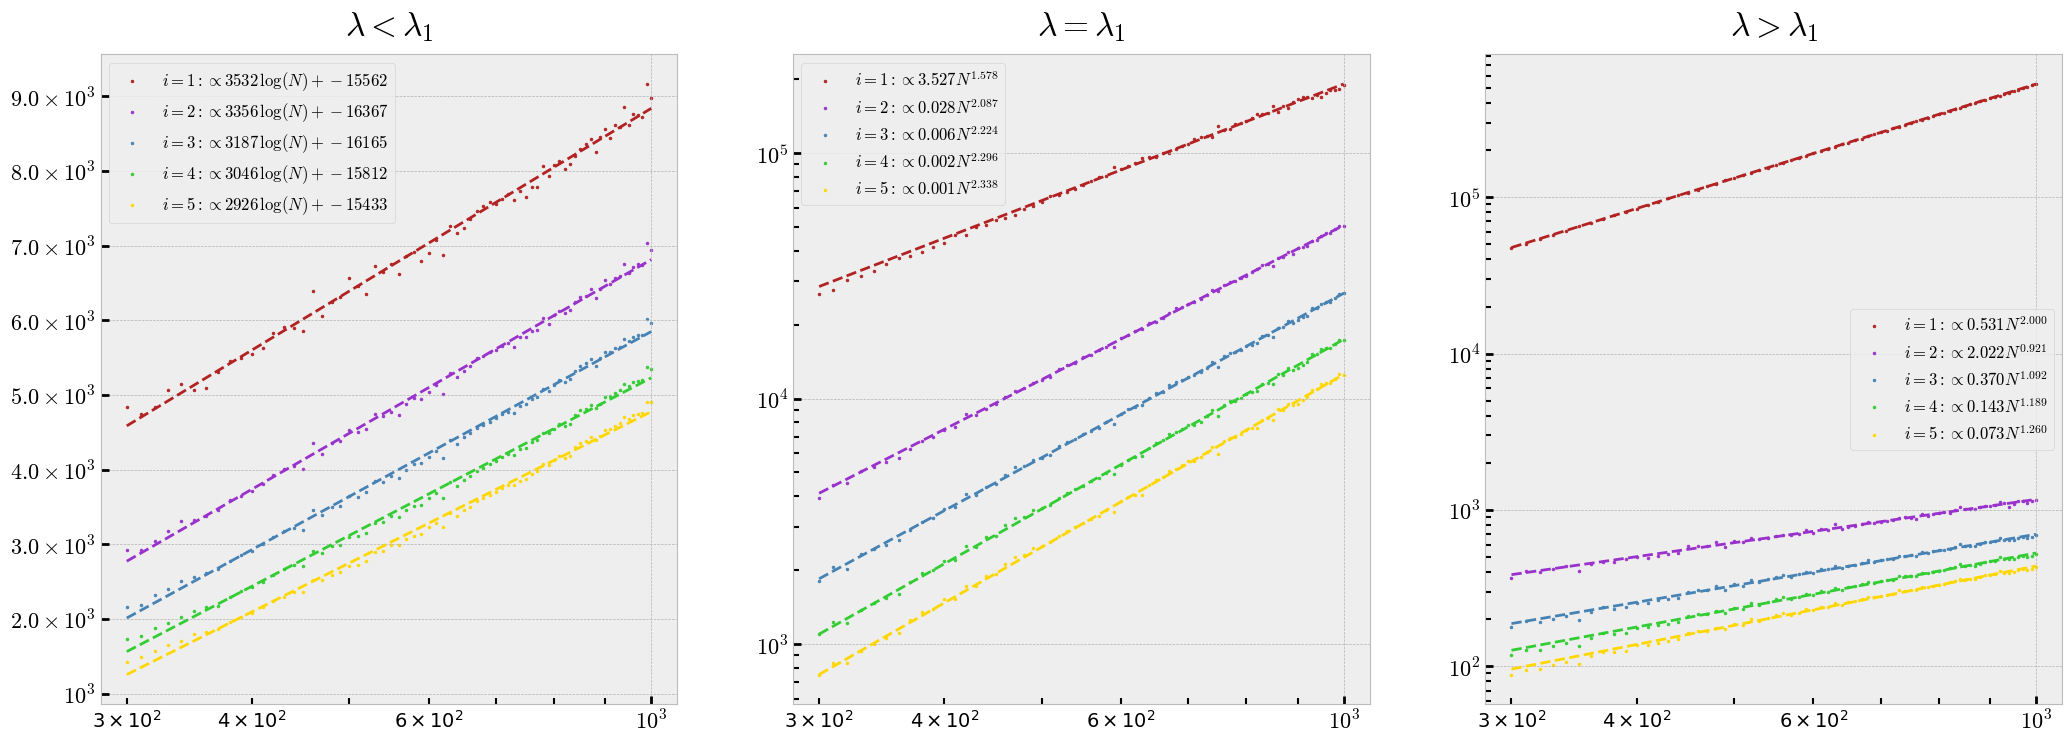

In [6]:
# Load data
df_plot = pd.read_csv(Folder / "Fig3e_11_data.csv")
  

# Define common colors and cluster columns
colors = ['firebrick', 'darkorchid', 'steelblue', 'limegreen', 'gold']
cluster_columns = [
    'max_cluster_size',            # i=1
    'second_max_cluster_size',     # i=2
    'third_max_cluster_size',      # i=3
    'fourth_max_cluster_size',     # i=4
    'fifth_max_cluster_size'       # i=5
]

# Create 3 subplots arranged horizontally
fig_width = 2.5 * (3 + 3/8)
fig, axes = plt.subplots(1, 3, figsize=(fig_width*3, fig_width))
ax1, ax2, ax3 = axes

# Marker size and tolerance
MarkerSize = 4  
tolerance = 1e-7  

# Function to format tick labels in scientific notation (e.g., 1.3 × 10^4)
def sci_notation(x, pos):
    if x == 0:
        return '0'
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / 10**exponent
    if coeff == 1:
        return r'$10^{%d}$' % exponent
    else:
        return r'${0:.1f} \times 10^{{{1}}}$'.format(coeff, exponent)

# Function to perform plotting and fitting for each subplot
def plot_and_fit(ax, df, fit_function, is_log_fit=False):
    # Group by 'Size' and compute the mean for each cluster column
    grouped = df.groupby(['Size']).mean().reset_index()
    
    handles = []
    labels = []
    
    # Loop over each cluster size column
    for i, cluster_column in enumerate(cluster_columns):
        N_values = grouped['Size'].values
        S_values = grouped[cluster_column].values
        scatter = ax.scatter(N_values, S_values, marker='o', s=MarkerSize, color=colors[i % len(colors)])
        
        # Fit the data using the provided fit function
        popt, _ = curve_fit(fit_function, N_values, S_values)
        # Generate a fit curve over the available range of N
        N_fit = np.linspace(min(N_values), max(N_values), 10)
        S_fit_curve = fit_function(N_fit, *popt)
        ax.plot(N_fit, S_fit_curve, linestyle='--', color=colors[i % len(colors)])
        
        # Format legend label based on fit type
        if is_log_fit:
            legend_label = f'$i={i+1}: \\propto {popt[0]:.0f}\\, \\log(N) + {popt[1]:.0f}$'
        else:
            legend_label = f'$i={i+1}: \\propto {popt[0]:.3f} N^{{{popt[1]:.3f}}}$'
        handles.append(scatter)
        labels.append(legend_label)
    
    ax.set_xscale('log')
    if not is_log_fit:
        ax.set_yscale('log')
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Format tick labels
    ax.tick_params(axis='both', which='major', labelsize=16, length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=14, length=4, width=1.5)
    
    ax.xaxis.set_major_formatter(FuncFormatter(sci_notation))
    ax.yaxis.set_major_formatter(FuncFormatter(sci_notation))
    
    ax.legend(handles, labels, fontsize=12, loc='best')

# --- Plot for lambda = 0.855 (Logarithmic Fit) ---
df_group1 = df_plot[np.isclose(df_plot['lambda_group'], 0.855, atol=tolerance)]
def log_func(N, a, b):
    return a * np.log(N) + b
plot_and_fit(ax1, df_group1, log_func, is_log_fit=True)
ax1.set_title(r'$\mathbf{\lambda < \lambda_1}$', fontsize=24, fontweight='bold', pad=14)

# --- Plot for lambda = 0.86055 (Power-Law Fit) ---
df_group2 = df_plot[np.isclose(df_plot['lambda_group'], 0.86055, atol=tolerance)]
def power_law(N, a, exponent):
    return a * N ** exponent
plot_and_fit(ax2, df_group2, power_law)
ax2.set_title(r'$\mathbf{\lambda = \lambda_1}$', fontsize=24, fontweight='bold', pad=14)

# --- Plot for lambda = 0.865 (Power-Law Fit) ---
df_group3 = df_plot[np.isclose(df_plot['lambda_group'], 0.865, atol=tolerance)]
plot_and_fit(ax3, df_group3, power_law)
ax3.set_title(r'$\mathbf{\lambda > \lambda_1}$', fontsize=24, fontweight='bold', pad=14)

plt.show()


# Fig 5

**Dataset Explanation:**

- **Lambda:** The control parameter of the system.
- **Average Counts:** A dictionary, keyed by the cluster size, containing the counts of clusters of that size over all selected time steps and realizations.

**Plot Details:**

- **Scatter Plot:**  Log-binned histogram of the cluster size distribution.
- **Curve Fit:**  The power-law fit by Kolmogorov-Smirnov (KS) method.

**Note:** percolating clusters are not trimmed, if any, in these plots.

Calculating best minimal value for power law fit


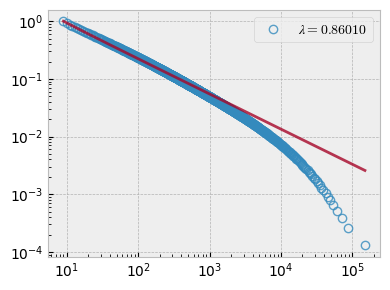

Calculating best minimal value for power law fit


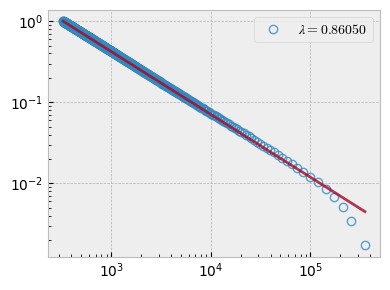

Calculating best minimal value for power law fit


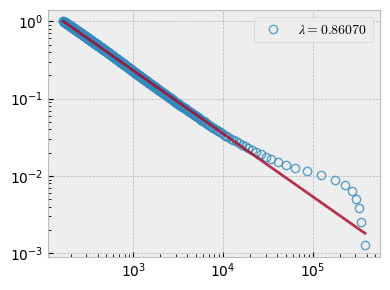

Calculating best minimal value for power law fit


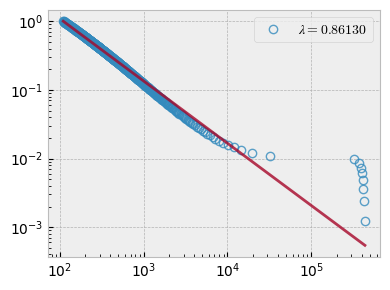

In [48]:
df_plot = pd.read_csv(Folder / "Fig5_data.csv")

def _uniform_downsample(sizes, counts, num_samples):
    sort_idx = np.argsort(sizes)
    sizes_sorted = sizes[sort_idx]
    counts_sorted = counts[sort_idx]
    counts_bins = counts_sorted.cumsum()
    step = counts_bins[-1] // num_samples
    step = step or 1
    subset_bins = np.arange(0, counts_bins[-1], step)
    subset_idx = np.searchsorted(counts_bins, subset_bins, side="right")
    return sizes_sorted[subset_idx]

for _, row in df_plot.iterrows():
    lmd = row["Lambda"]
    avg_counts = eval(row["Average Counts"])
    sizes = np.asarray(list(avg_counts.keys()), dtype=int)
    counts = np.asarray(list(avg_counts.values()), dtype=float)
    counts = np.round(counts / np.min(counts)).astype(np.uint64)

    sorted_idx = np.argsort(sizes)
    sizes_uniq = sizes[sorted_idx]
    counts_uniq = counts[sorted_idx]
    pdf = counts_uniq / np.sum(counts_uniq)
    ccdf = 1 - np.cumsum(pdf)

    sizes_samp = _uniform_downsample(sizes, counts, 4000000)

    fit = powerlaw.Fit(sizes_samp, discrete=True, estimate_discrete=True)
    alpha = fit.alpha; smin = int(fit.xmin)

    sizes_trunc = sizes_uniq[sizes_uniq >= smin]
    counts_trunc = counts_uniq[sizes_uniq >= smin]
    pdf_trunc = counts_trunc / np.sum(counts_trunc)
    ccdf_trunc = 1 - np.cumsum(pdf_trunc)

    fig, ax = plt.subplots(figsize=(4, 3))
    fit.plot_ccdf(c='C0', marker='o', fillstyle='none', ls='', alpha=0.8, ax=ax, label=f'$λ={lmd:.5f}$')
    fit.power_law.plot_ccdf(ls='-', lw=2, ax=ax, alpha=0.8, c='C1')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Fig 6

**Dataset Explanation:**

- **Lambda:** The control parameter of the system.
- **Average Counts:** A dictionary, keyed by the cluster size, containing the counts of clusters of that size over all selected time steps and realizations.

**Plot Details:**

- **Scatter Plot:**  Log-binned histogram of the cluster size distribution.
- **Curve Fit:**  The power-law fit by Kolmogorov-Smirnov (KS) method.

**Note:** percolating clusters above the percolation threshold `percolating_thld = 0.86055` are trimmed in these plots.

Calculating best minimal value for power law fit


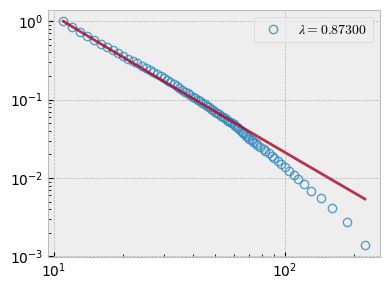

Calculating best minimal value for power law fit


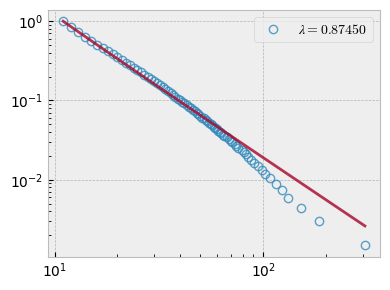

Calculating best minimal value for power law fit


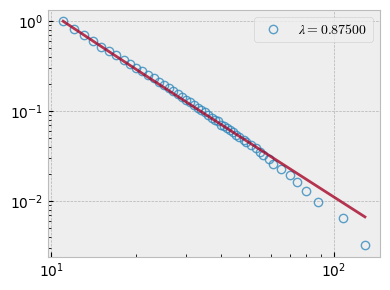

Calculating best minimal value for power law fit


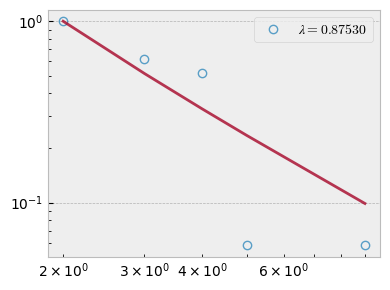

In [50]:
df_plot = pd.read_csv(Folder / "Fig6_data.csv")

def _sizes_counts(lambda_df, lmd, percolating_thld = 0.8625):
    all_size_counts = defaultdict(int)
    for size_counts in lambda_df['size_counts']:
        size_counts = eval(size_counts)
        if lmd > percolating_thld:
            size_counts_arr = np.array(list(size_counts.items()), dtype=np.uint64) # Convert to numpy array once
            max_cluster_idx = np.argmax(size_counts_arr[:, 0]) # Find the index of the largest cluster
            size_counts_arr = np.delete(size_counts_arr, max_cluster_idx, axis=0) # Remove the largest cluster
            for size, count in size_counts_arr:
                all_size_counts[size] += count
        else:
            for size, count in size_counts.items():
                all_size_counts[size] += count

    sizes = np.array(list(all_size_counts.keys()), dtype=np.uint64)
    counts = np.array(list(all_size_counts.values()), dtype=np.uint64) #/ len(lambda_df)
    return sizes, counts

def _uniform_downsample(sizes, counts, num_samples):
    sort_idx = np.argsort(sizes)
    sizes_sorted = sizes[sort_idx]
    counts_sorted = counts[sort_idx]
    counts_bins = counts_sorted.cumsum()
    step = counts_bins[-1] // num_samples
    step = step or 1
    subset_bins = np.arange(0, counts_bins[-1], step)
    subset_idx = np.searchsorted(counts_bins, subset_bins, side="right")
    return sizes_sorted[subset_idx]

percolating_thld = 0.86055

for lmd in df_plot["lambda"].unique():
    lambda_df = df_plot[df_plot["lambda"] == lmd]
    sizes, counts = _sizes_counts(lambda_df, lmd, percolating_thld=percolating_thld)

    sorted_idx = np.argsort(sizes)
    sizes_uniq = sizes[sorted_idx]
    counts_uniq = counts[sorted_idx]
    pdf = counts_uniq / np.sum(counts_uniq)
    ccdf = 1 - np.cumsum(pdf)

    sizes_samp = _uniform_downsample(sizes, counts, 4000000)

    fit = powerlaw.Fit(sizes_samp, discrete=True, estimate_discrete=True)
    alpha = fit.alpha; smin = int(fit.xmin)

    sizes_trunc = sizes_uniq[sizes_uniq >= smin]
    counts_trunc = counts_uniq[sizes_uniq >= smin]
    pdf_trunc = counts_trunc / np.sum(counts_trunc)
    ccdf_trunc = 1 - np.cumsum(pdf_trunc)

    fig, ax = plt.subplots(figsize=(4, 3))
    fit.plot_ccdf(c='C0', marker='o', fillstyle='none', ls='', alpha=0.8, ax=ax, label=f'$λ={lmd:.5f}$')
    fit.power_law.plot_ccdf(ls='-', lw=2, ax=ax, alpha=0.8, c='C1')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Fig 7:

**Dataset Explanation:**

- **State Matrices:**  
  The simulation produces a sequence of state matrices representing the lattice of the logistic GOL. In these matrices, each cell is either active or quiescent (zero state).

- **Cluster Images:**  
  For each state matrix, a corresponding cluster image is generated by identifying connected regions (clusters) of cells sharing the same state. In particular, the analysis focuses on the vacuum (zero-state) clusters.

- **λ (lambda):**  
  The control parameter of the system is set close to λₐ (here, λ = 0.87499). This value is chosen to illustrate the dynamics near the inactive-active transition where power-law behavior emerges.

**Plot Details:**
In the provided simulation, a GIF is created by saving image frames from the last few simulation steps. In each frame:
  - The full grid (with the overlaid cluster mask) is shown alongside a zoomed-in view of the cluster region.
  - As the simulation evolves, the active regions propagate and cover to make islands inside the dominant vacuum cluster.
  - This process results in a distribution of zero-state clusters whose sizes follow a power-law. The exponential cutoff in the distribution shifts with grid size, reflecting finite-size effects.

**Key Observations:**

- **Around λₐ:**  
  The lattice is dominated by a large vacuum cluster that acts as a “playground” for activity. The activity does not vanish but rather spreads along the boundaries of the quiescent regions.
  
- **Power-Law Emergence:**  
  The sizes of the smaller zero-state clusters that are “encircled” by activity exhibit power-law behavior. This suggests a form of scale invariance in the cluster distribution near λₐ.
  
- **Self-Organized Criticality:**  
  Unlike the critical behavior near λₚ, where the percolating cluster emerges through a more abrupt transition, the power-law behavior near λₐ reflects a spontaneous self-organized critical (SOC) regime. Here, the system continually “perturbs” itself via changes in neighborhood configurations, maintaining persistent activity without external forcing.
  
  **Note:** Due to the resolution limits of the colormap, some grid points adjacent to the cluster appear to have the same color as the 0 (quiescent) cluster. In reality, these points have nonzero values that are very close to 0, which effectively disconnects the second cluster from the surrounding giant cluster.  
    **Note:** Here, a second-largest cluster of size 109 is observed on a small grid for computational convenience. However, as grid sizes and simulation runtimes increase, the power-law dynamics lead to the formation of progressively larger encircled clusters. Note that larger cluster observations require substantially longer wait times due to the underlying power-law scaling. 

AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

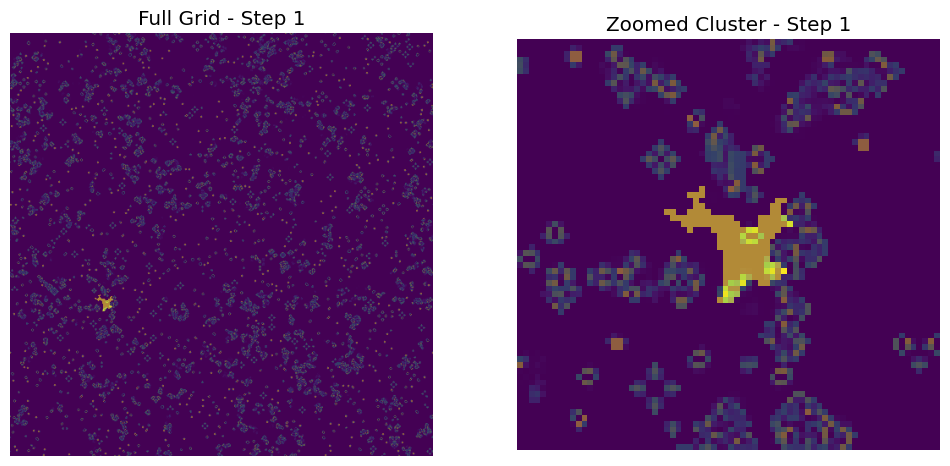

In [3]:
# --- Union-Find Implementation ---
class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))
        self.rank = [0] * size
        self.size = [1] * size

    def find(self, node):
        if self.parent[node] != node:
            self.parent[node] = self.find(self.parent[node])
        return self.parent[node]

    def union(self, node1, node2):
        root1, root2 = self.find(node1), self.find(node2)
        if root1 != root2:
            if self.rank[root1] > self.rank[root2]:
                self.parent[root2] = root1
                self.size[root1] += self.size[root2]
            elif self.rank[root1] < self.rank[root2]:
                self.parent[root1] = root2
                self.size[root2] += self.size[root1]
            else:
                self.parent[root2] = root1
                self.rank[root1] += 1
                self.size[root1] += self.size[root2]

# --- Helper Functions ---
def get_index(x, y, rows, cols):
    return (x % rows) * cols + (y % cols)

def wrap_index(value, max_value):
    return value % max_value

def analyze_clusters(grid, uf):
    rows, cols = grid.shape
    # Connect each cell with its right and bottom neighbors (periodic)
    for i in range(rows):
        for j in range(cols):
            right = (i, (j + 1) % cols)
            bottom = ((i + 1) % rows, j)
            if grid[i, j] == grid[right]:
                uf.union(get_index(i, j, rows, cols), get_index(right[0], right[1], rows, cols))
            if grid[i, j] == grid[bottom]:
                uf.union(get_index(i, j, rows, cols), get_index(bottom[0], bottom[1], rows, cols))
    
    # Collect cluster sizes
    cluster_sizes = {}
    for i in range(rows):
        for j in range(cols):
            root = uf.find(get_index(i, j, rows, cols))
            cluster_sizes[root] = cluster_sizes.get(root, 0) + 1

    sorted_clusters = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)
    second_largest = sorted_clusters[1] if len(sorted_clusters) > 1 else None
    return uf, second_largest

def zoom_in_on_cluster(cluster_image, real_grid, padding=70):
    cluster_indices = np.argwhere(cluster_image > 0)
    if cluster_indices.size == 0:
        return real_grid, cluster_image

    x_min, y_min = cluster_indices.min(axis=0)
    x_max, y_max = cluster_indices.max(axis=0)

    x_min = wrap_index(x_min - padding, real_grid.shape[0])
    y_min = wrap_index(y_min - padding, real_grid.shape[1])
    x_max = wrap_index(x_max + padding, real_grid.shape[0])
    y_max = wrap_index(y_max + padding, real_grid.shape[1])

    if x_min > x_max:
        zoomed_real_grid = np.vstack((real_grid[x_min:], real_grid[:x_max+1]))
        zoomed_cluster_image = np.vstack((cluster_image[x_min:], cluster_image[:x_max+1]))
    else:
        zoomed_real_grid = real_grid[x_min:x_max+1]
        zoomed_cluster_image = cluster_image[x_min:x_max+1]

    if y_min > y_max:
        zoomed_real_grid = np.hstack((zoomed_real_grid[:, y_min:], zoomed_real_grid[:, :y_max+1]))
        zoomed_cluster_image = np.hstack((zoomed_cluster_image[:, y_min:], zoomed_cluster_image[:, :y_max+1]))
    else:
        zoomed_real_grid = zoomed_real_grid[:, y_min:y_max+1]
        zoomed_cluster_image = zoomed_cluster_image[:, y_min:y_max+1]

    return zoomed_real_grid, zoomed_cluster_image

# --- Folgol Simulation Functions ---
def folgol_get_vL(order, lamda):
    L = 2 ** (order + 1)
    v = np.array([0, 1])
    for _ in range(order):
        v = np.concatenate(((1 - lamda) * v, v + lamda * (1 - v)))
    return v, L

def folgol_initialize(N, M, L):
    a = np.zeros((N, N), dtype=int)
    a[N//2 - M//2:N//2 + M//2, N//2 - M//2:N//2 + M//2] = np.random.randint(L, size=(M, M))
    return a

def folgol_step(a, v, kernel, L):
    s = v[a]
    b = convolve2d(s, kernel, mode='same', boundary='wrap')
    a = (L // 2 + a // 2) * ((b >= 2.5) & (b <= 3.5)) \
        + a * ((b >= 1.5) & (b < 2.5)) \
        + (a // 2) * ((b < 1.5) | (b > 3.5))
    return a

def run_simulation(order, lamda, N, M, T, kernel, target_size=100):
    v, L = folgol_get_vL(order, lamda)
    a = folgol_initialize(N, M, L)
    uf = UnionFind(M * N)
    cluster_image = np.zeros_like(a)
    last_steps = []
    
    for n in range(T):
        a = folgol_step(a, v, kernel, L)
        last_steps.append(a.copy())
        if len(last_steps) > 50:
            last_steps.pop(0)

        if n > T / 2:
            uf = UnionFind(M * N)  # Reinitialize for current step
            uf, second_largest = analyze_clusters(a, uf)
            if second_largest and second_largest[1] > 90:
                root, _ = second_largest
                color_index = 1  # Second-largest cluster color
                for i in range(N):
                    for j in range(M):
                        if uf.find(get_index(i, j, N, M)) == root:
                            cluster_image[i, j] = color_index
                return last_steps, cluster_image, second_largest
    return last_steps, cluster_image, None

# --- Simulation Parameters ---
order = 10
lamdas = [0.87499]
N = 500 
M = 500 
T = int(1e3)
kernel = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]])

# --- Run Simulation and Create GIF Frames ---
frames = []

for lamda in lamdas:
    last_steps, cluster_image, second_largest = run_simulation(order, lamda, N, M, T, kernel)
    
    # Create frames for the last steps with zoomed cluster view
    for idx, real_grid in enumerate(last_steps):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
        zoomed_real, zoomed_cluster = zoom_in_on_cluster(cluster_image, real_grid, padding=25)
        
        # Left: full grid with overlay
        axs[0].imshow(real_grid)
        axs[0].imshow(cluster_image, alpha=0.6)
        axs[0].set_title(f"Full Grid - Step {idx+1}")
        axs[0].axis('off')
        
        # Right: zoomed view with overlay
        axs[1].imshow(zoomed_real)
        axs[1].imshow(zoomed_cluster, alpha=0.6)
        axs[1].set_title(f"Zoomed Cluster - Step {idx+1}")
        axs[1].axis('off')
        
        # Display cluster size on the last frame
        if idx == len(last_steps) - 1 and second_largest is not None:
            axs[1].text(0.5, -0.1, f"Cluster Size: {second_largest[1]}",
                        ha='center', va='center', transform=axs[1].transAxes,
                        fontsize=12, color='red')
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)
        plt.close(fig)

# Set frame durations: all frames 0.25 sec except the last 10 sec
durations = [0.25] * (len(frames) - 1) + [15.0]

gif_bytes = io.BytesIO()
import imageio
imageio.mimsave(gif_bytes, frames, format='GIF', duration=durations)
gif_bytes.seek(0)

# Display the GIF inline
display(Image(data=gif_bytes.getvalue()))


# Fig 10:

**Dataset Explanation:**

- **selected_lambda**: The representative $\lambda$ value for the data group (e.g., $\lambda = 0.86$ or $\lambda = 0.874$).
- **cluster_rank**: The rank of the cluster (from 1 to 5, with 1 being the largest cluster).
- **box_size**: The box size $\epsilon$ used in the boxcounting method.
- **box_count**: The number of boxes $N(\epsilon)$ that contain part of the cluster, averaged over multiple realizations.

**Plot Details:**

- The plots display the (averaged) box counts $\langle N(\epsilon) \rangle$ versus box sizes $\epsilon$ on log-log scales.
- Two subplots are generated side-by-side: 
  - **Panel (a)** for $\lambda = 0.86$, 
  - **Panel (b)** for $\lambda = 0.874$.
- The capacity dimension $d_c$ is determined from the negative slope of the log-log plot in the small box size region (typically $\epsilon \in [1, 6]$), according to:
  
  $$
  \langle N(\epsilon) \rangle \propto \epsilon^{-d_c} \quad \rightarrow \quad d_c = - \lim_{\epsilon \to 0} \frac{\log \langle N(\epsilon) \rangle}{\log \epsilon}.
  $$

- As $\lambda$ increases from 0.86 to 0.874, the largest cluster gradually separates from the rest, exhibiting an increasing capacity dimension, while the other clusters’ capacity dimensions decrease.

**Key Observations:**

- **Panel (a)** ($\lambda = 0.86$): Clusters display lower capacity dimensions.
- **Panel (b)** ($\lambda = 0.874$): The largest cluster shows an increased capacity dimension, indicating its system-spanning nature, whereas the subleading clusters exhibit lower capacity dimensions.

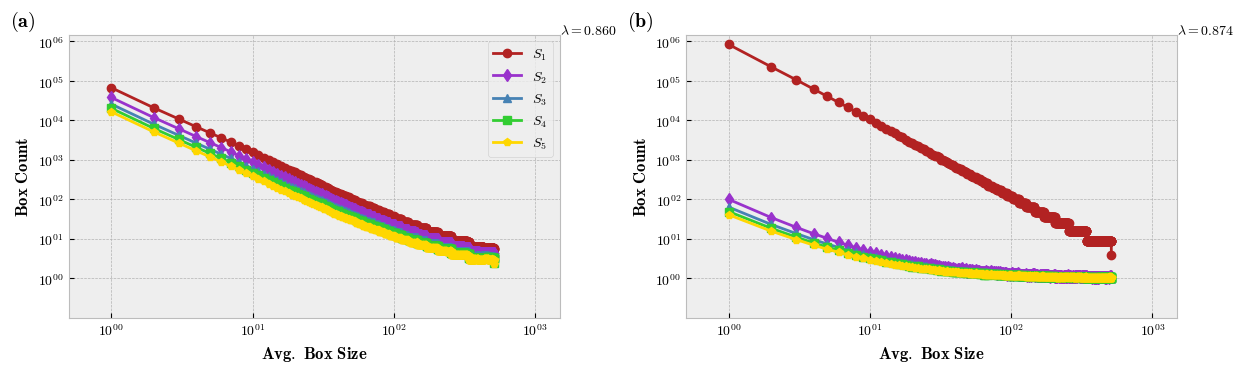

In [4]:
# Load data
df_plot = pd.read_csv(Folder / "Fig10_data.csv")

# Define common markers, colors, and subcaptions (if needed)
markers = ['o', 'd', '^', 's', 'p']
colors = ['firebrick', 'darkorchid', 'steelblue', 'limegreen', 'gold']
subcaption = ['(a)', '(b)']  # One for each panel

# Determine unique lambda groups (should be two)
lambda_groups = sorted(df_plot['selected_lambda'].unique())

# Create 2 subplots side-by-side
fig, axs = plt.subplots(1, 2, figsize=(6.25*2, 6.25/1.628))

# Function to format tick labels in scientific notation
def format_ticks(tick):
    base, exp = f"{tick:.0e}".split("e")
    if exp[0] == "-":
        return f"$10^{{-{exp[1:]}}}$"
    else:
        return f"$10^{{{exp[1:]}}}$"

ax_count = 0
for ax, sel_lambda in zip(axs, lambda_groups):
    # Filter data for this lambda group
    df_group = df_plot[df_plot['selected_lambda'] == sel_lambda]
    
    # Loop over cluster ranks 1 to 5 and plot
    for i in range(1, 6):
        df_i = df_group[df_group['cluster_rank'] == i]
        ax.loglog(df_i['box_size'], df_i['box_count'],
                  label=f'$S_{{{i}}}$',
                  linewidth=2, markersize=6,
                  color=colors[i-1], marker=markers[i-1])
    
    ax.set_xlabel('$\\bf{Avg.\\ Box\\ Size}$')
    ax.set_ylabel('$\\bf{Box\\ Count}$')
    ax.set_title(f'$\\bf{{ {subcaption[ax_count]} }}$', fontweight='bold', x=-1.5/16)
    ax.text(1, 1, f'$\\bf{{ \\lambda = {sel_lambda:.3f} }}$', transform=ax.transAxes)
    
    ax.set_xlim([0.5, 1500])
    ax.set_ylim([0.05, 1.5e6])
    
    # Adjust x-ticks: Use the ticks from the axis and format them
    xticks = ax.get_xticks()[2:-1]
    ax.set_xticks(xticks)
    ax.set_xticklabels([format_ticks(tick) for tick in xticks])
    
    # Set y-ticks manually and format
    yticks = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
    ax.set_yticks(yticks)
    ax.set_yticklabels([format_ticks(tick) for tick in yticks])
    
    ax.set_xlim([0.5, 1500])
    ax.set_ylim([0.1, 1.5e6])         
    ax_count += 1

axs[0].legend()

# Optionally remove minor ticks
axs[0].minorticks_off()
axs[1].minorticks_off()

plt.tight_layout()
plt.show()


# Fig 12:

This notebook demonstrates how to load and plot data from the file `combined_plot_data.csv`.

## Dataset Explanation

The CSV file contains the following columns:

- **lambda**: Simulation parameter values in the range [0.85, 0.88].
- **second_max_cluster_size**: Measured size of the second largest cluster.
- **Size**: The system size (N) corresponding to each measurement.
- **norm**: Normalized second largest cluster size, computed as:
  
  $$
  \text{norm} = \frac{\langle S_2(N) \rangle}{N^2}
  $$

## Plot Details

The plot shows the evolution of 

$$
\frac{\langle S_2(N) \rangle}{N^2}
$$

as a function of $\lambda$ for different system sizes (e.g., N = 400, 600, 800, 1024). A vertical dashed line at $\lambda \approx 0.8605$ marks the approximate critical point $\lambda_P$.

**Key observations:**

- As $\lambda_P$ is approached, the second largest cluster grows rapidly.
- For larger system sizes, the peak in the normalized cluster size becomes sharper.
- This behavior is consistent with percolation theory, where in the limit $N \to \infty$ the divergence of $\langle S_2(N) \rangle$ signals the emergence of a percolating cluster and a phase transition.

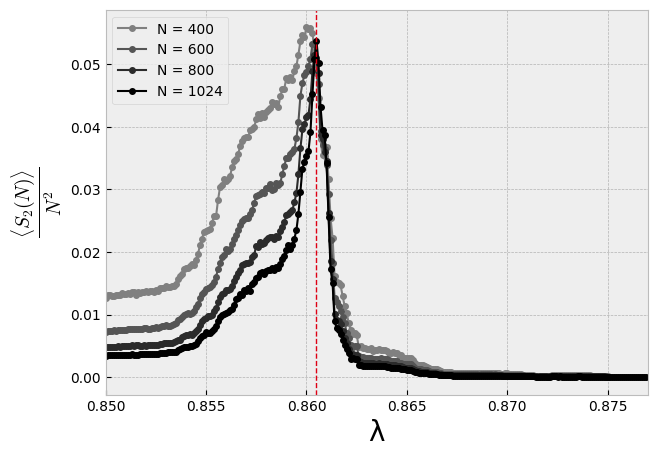

In [5]:
# Load data
df_plot = pd.read_csv(Folder / "Fig12_data.csv")
 
# Create a new figure with a specified size (width=10 inches, height=6 inches)
plt.figure(figsize=(7, 5))
 

# Determine the unique system sizes in the dataset
unique_sizes = sorted(df_plot["Size"].unique())

# Generate a range of color shades for each system size (from lighter to darker)
colors = np.linspace(0.5, 0.0, len(unique_sizes))

# Loop through each system size and plot the corresponding data
for i, size in enumerate(unique_sizes):
    # Filter the DataFrame for the current system size
    data = df_plot[df_plot["Size"] == size]
    # Plot the normalized cluster size (norm) versus lambda
    plt.plot(data["lambda"], data["norm"], 'o-', color=str(colors[i]),
             linewidth=1.5, markersize=4, label=f'N = {size}')

# Add a vertical dashed line at λ = 0.8605 to mark the approximate critical point (λₚ)
plt.axvline(x=0.8605, linestyle='--', linewidth=1, c='#DE0014')

# Set the x-axis and y-axis labels with larger font sizes
plt.xlabel('λ', fontsize=20)
plt.ylabel(r'$\frac{\langle S_2(N) \rangle }{N^2}$', fontsize=20)

# Add a legend in the upper left to identify the different system sizes
plt.legend(fontsize=10, loc='upper left')

# Limit the x-axis range for clarity
plt.xlim(0.85, 0.877) 
# Display the final plot
plt.show()


# Fig 12 inset:

**Dataset Explanation:**

- **lambda**: The simulation parameter values.
- **Size**: The system size (N) corresponding to each measurement.
- **second_max_cluster_size**: The measured size of the second largest cluster.

**Plot Details:**

- The x-axis represents $N^2$ (square of the system size).
- The y-axis shows the mean second largest cluster size.
- Different markers and colors are used for each specified $\lambda$ value.
- A legend indicates the corresponding $\lambda$ value (formatted to 4 decimal places).

This plot helps visualize how the second largest cluster evolves with the system size for the specified $\lambda$ values. 

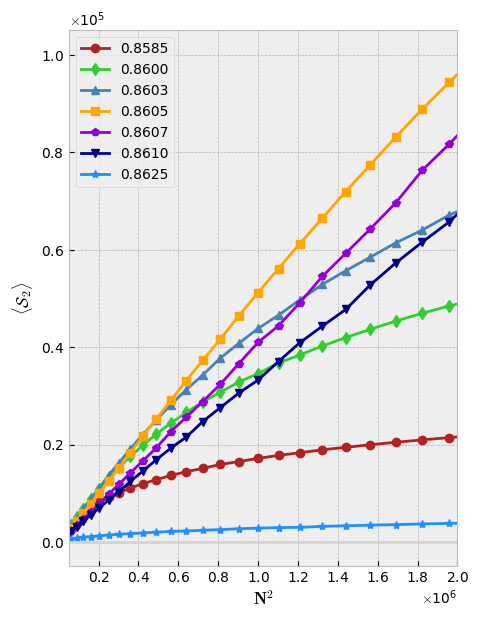

In [6]:
# Load data
df_plot = pd.read_csv(Folder / "Fig12_data_inset.csv")

# Define the specific lambda values and tolerance (same as before)
plot_lambdas = np.array([0.8585, 0.86, 0.8603, 0.8605, 0.8607, 0.861, 0.8625])
tolerance = 1e-7

# Pivot the table to have 'Size' as the index and lambda values as columns
pivot_table = df_plot.pivot(index='Size', columns='lambda', values='second_max_cluster_size')

# Filter pivot table columns to include only the specified lambda values using tolerance
plot_lambdas_filtered = [col for col in pivot_table.columns if any(np.isclose(col, plot_lambdas, atol=tolerance))]

if not plot_lambdas_filtered:
    raise KeyError("None of the specified lambdas are present in the pivot table columns.")

# Set up the figure size
fig_width =1.8 * (3 + 3/8)
fig, ax = plt.subplots(1, figsize=(fig_width / 1.3, fig_width), layout='constrained')

# Define markers and colors (reusing the settings from above)
markers = ['o', 'd', '^', 's', 'p', 'v', '*']
colors = [
    [0.698, 0.133, 0.133],  # Dark Red
    [0.196, 0.804, 0.196],  # Lime Green
    [0.275, 0.51, 0.706],   # Steel Blue
    [1.000, 0.647, 0.000],  # Orange
    [0.580, 0.000, 0.827],  # Purple
    [0.000, 0.000, 0.545],  # Navy Blue
    [0.118, 0.565, 1.000],  # Deep Sky Blue
]

# Plot each specified lambda value's data
for i, lambda_value in enumerate(plot_lambdas_filtered):
    ax.plot((pivot_table.index) ** 2, pivot_table[lambda_value], 
            marker=markers[i % len(markers)], linestyle='-', 
            markersize=6, color=colors[i % len(colors)], label=f'{lambda_value:.4f}')

# Add a horizontal light gray line at y = 0
ax.axhline(y=0.0, color='lightgray')

# Set the axis labels with LaTeX formatting
ax.set_xlabel('$\\bf{N^2}$')
ax.set_ylabel('$\\bf{\\langle \\mathcal{S}_2 \\rangle}$')

# Retrieve the legend handles and labels
handles, labels = ax.get_legend_handles_labels()
new_labels = [f'{float(label):.4f}' if label.replace('.', '', 1).isdigit() else label for label in labels]

# Filter the legend to include only the specified lambda values
filtered_handles_labels = [(h, l) for h, l in zip(handles, new_labels) if any(np.isclose(float(l), plot_lambdas, atol=tolerance))]
filtered_handles, filtered_labels = zip(*filtered_handles_labels)

# Limit legend entries to the first 7 (if there are more)
filtered_handles = filtered_handles[:7]
filtered_labels = filtered_labels[:7]

# Display the legend
ax.legend(handles=filtered_handles, labels=filtered_labels, ncol=1, loc='best')

# Set the x-axis limits and ticks
ax.set_xlim(0.05e6, 2e6)
ax.set_xticks(np.arange(0.2e6, 2.1e6, 0.2e6))
ax.ticklabel_format(axis='both', scilimits=[0, 0], useMathText=True)

# Adjust the layout and display the plot
plt.show()



# FIG. 13:

**Dataset Explanation:**

The dataset for this analysis comprises cluster size measurements for various $\lambda$ values. From these measurements, the empirical probability density function (PDF) of cluster sizes is computed, capturing the distribution of clusters across the system.

**Plot Details:**

- **Panel (a):**  
  This panel shows the evolution of the PDFs as $\lambda$ increases towards the percolation threshold $\lambda_P$ from below. Key features include:
  - The PDF tails become fatter, evidenced by both a shift towards higher cluster sizes and an increased spread in the tail.
  - At $\lambda_P$, the tail extends up to the system size—demonstrating scale invariance regardless of grid size.
 
**Key Observations:**

- **Panel (a):** As $\lambda$ approaches $\lambda_P$, the tail of the PDF shifts to larger cluster sizes and becomes broader, indicating an increased occurrence of large clusters and the onset of scale invariance.
- **Panel (b):** When the percolating cluster is excluded at $\lambda_A$, the remaining clusters conform to a pure power-law distribution, highlighting the distinct behavior of the percolating cluster compared to subcritical clusters.

<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1063643/3206463017.py:34: SyntaxWarning: invalid escape sequence '\l'
  label=f'$\lambda={lam}$', markersize=2,


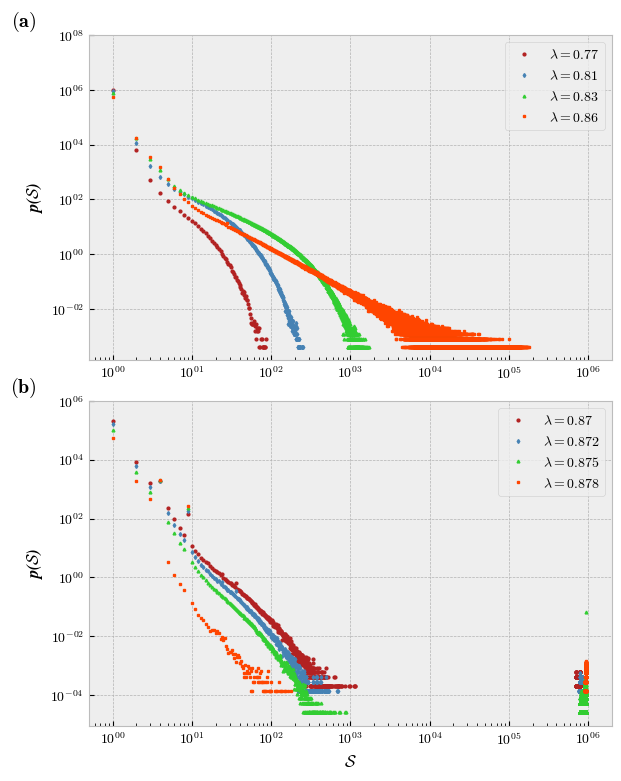

In [7]:
# Load data
df_plot = pd.read_csv(Folder / "Fig13_data.csv")

 
markers = ['o', 'd', '^', 's', 'p']  
colors = [[0.698, 0.133, 0.133], [0.275, 0.51, 0.706], [0.196, 0.804, 0.196], [1, 0.27, 0]]
subcaption = ['(a)', '(b)']

# Determine unique groups (should be two) from the extracted data
groups = sorted(df_plot['group'].unique())

# Set figure width (using your defined width)
width = 2*(3+3/8)
fig, axs = plt.subplots(2, 1, figsize=(width, 1.33*width), layout='tight', 
                        gridspec_kw={'wspace': 0, 'hspace': 1/8})

# Function to format tick labels in scientific notation
def format_ticks(tick):
    base, exp = f"{tick:.0e}".split("e")
    if exp[0] == "-":
        return f"$10^{{-{exp[1:]}}}$"
    else:
        return f"$10^{{{exp[1:]}}}$"

# Loop over each group and plot the data
for ax, group in zip(axs, groups):
    df_group = df_plot[df_plot['group'] == group]
    # For each unique lambda value within the group, plot its data
    unique_lambdas = sorted(df_group['selected_lambda'].unique())
    for idx, lam in enumerate(unique_lambdas):
        df_lam = df_group[df_group['selected_lambda'] == lam]
        ax.loglog(df_lam['box_size'], df_lam['avg_count'],
                  marker=markers[idx % len(markers)], linestyle='None',
                  label=f'$\lambda={lam}$', markersize=2,
                  color=colors[idx % len(colors)])
    ax.legend()
    ax.set_xlim(0.5, 2e6)
    xticks = ax.get_xticks()[2:-2]
    ax.set_xticks(xticks)
    ax.set_xticklabels([format_ticks(tick) for tick in xticks])
    yticks = ax.get_yticks()[2:-1]
    ax.set_yticks(yticks)
    ax.set_yticklabels([format_ticks(tick) for tick in yticks])
    ax.set_xlim([0.5, 2e6])
     
    
# Set titles and labels for subplots
axs[0].set_title(f'$\\bf{{ {subcaption[0]} }}$', x=-1/8)
axs[1].set_title(f'$\\bf{{ {subcaption[1]} }}$', x=-1/8)
axs[0].set_xlabel('')
axs[1].set_xlabel(r'$\mathcal{S}$')
axs[0].set_ylabel(r'$\bfit p(\mathcal{S})$')
axs[1].set_ylabel(r'$\bfit p(\mathcal{S})$')

 
plt.show()


# FIG. 15:

**Dataset Explanation:**

- **sizes_uniq:** Unique cluster size values from the empirical data.
- **pdf:** The empirical probability density function (PDF) corresponding to sizes_uniq.
- **ccdf:** The complementary cumulative distribution function (CCDF) corresponding to sizes_uniq.
- **sizes_trunc, pdf_trunc, ccdf_trunc:** The truncated arrays used for fitting the power‐law model.
- **label:** A string label (e.g. "Size = 500.00000") indicating the lattice size or sample identifier.

**Plot Details:**

- **Top-Left Panel:** Untruncated PDF data (plotted on a log–log scale).
- **Top-Right Panel:** PDF data with the fitted power‐law curve (dashed line).
- **Bottom-Left Panel:** Untruncated CCDF data (log–log scale).
- **Bottom-Right Panel:** CCDF data with the fitted power‐law curve (dashed line).

Different colors are used for different sample sizes and the fits are shown as dashed lines in a gray-to-black gradient.

In [ ]:
# ---------------------------------------------------------
# Utility Functions
# ---------------------------------------------------------
def _sizes_counts(df_slice):
    """
    Aggregate size_counts dictionaries from a DataFrame slice and return
    arrays of unique sizes and their total counts.
    """
    all_size_counts = defaultdict(int)
    for size_counts in df_slice['size_counts']:
        for size, count in size_counts.items():
            all_size_counts[size] += count

    sizes = np.array(list(all_size_counts.keys()), dtype=np.uint64)
    counts = np.array(list(all_size_counts.values()), dtype=np.uint64)
    return sizes, counts

def _uniform_downsample(sizes, counts, num_samples):
    """
    Uniform downsampling of discrete sizes according to their frequency.
    """
    sort_idx = np.argsort(sizes)
    sizes_sorted = sizes[sort_idx]
    counts_sorted = counts[sort_idx]
    counts_bins = counts_sorted.cumsum()
    step = counts_bins[-1] // num_samples
    if step == 0:
        step = 1
    subset_bins = np.arange(0, counts_bins[-1], step)
    subset_idx = np.searchsorted(counts_bins, subset_bins, side='right')
    return sizes_sorted[subset_idx]

# ---------------------------------------------------------
# Numba-accelerated goodness-of-fit helpers
# ---------------------------------------------------------
@njit
def _compute_gof(q, qmins):
    """
    Compute the maximum distance between empirical CDF and 
    the power-law model's CDF for each candidate qmin.
    """
    dat = []
    for qmin in qmins:
        zq = q[q >= qmin]
        nq = len(zq)
        a = nq / np.sum(np.log(zq / qmin))
        cq = np.arange(nq) / nq
        cf = 1 - (qmin / zq) ** a
        dat.append(np.max(np.abs(cq - cf)))
    return dat

@jit(nopython=True, parallel=True, fastmath=True, cache=True)
def _compute_quiet_continuous(x, xmin, reps=1000, limit=None, sample=None, seed=None):
    """
    Bootstrap-based p-value calculation for continuous power-law fits.
    Accelerated via numba in parallel.
    """
    if seed is not None:
        np.random.seed(seed)
    N = len(x)
    nof = []

    # Original sample stats
    z = x[x >= xmin]
    nz = len(z)
    y = x[x < xmin]
    ny = len(y)
    alpha = 1 + nz / np.sum(np.log(z / xmin))
    cz = np.arange(nz) / nz
    cf = 1 - (xmin / np.sort(z)) ** (alpha - 1)
    gof = np.max(np.abs(cz - cf))
    pz = nz / N

    # Semiparametric bootstrap
    for B in range(reps):
        n1 = np.sum(np.random.random(N) > pz)
        q1 = y[np.random.randint(0, ny, n1)]
        n2 = N - n1
        q2 = xmin * (1 - np.random.random(n2)) ** (-1 / (alpha - 1))
        q = np.sort(np.concatenate((q1, q2)))

        qmins = np.unique(q)[:-1]
        if limit is not None:
            qmins = qmins[qmins <= limit]
        if sample is not None:
            idxs = np.unique(np.round(np.linspace(0, len(qmins) - 1, sample)).astype(int))
            qmins = qmins[idxs]

        dat = _compute_gof(q, qmins)
        nof.append(min(dat))
    p = np.sum(np.array(nof) >= gof) / reps
    return p, gof

# ---------------------------------------------------------
# Main p-value function for power-law fit
# ---------------------------------------------------------
def plpvalue(
    x, xmin,
    vec=np.arange(1.50, 3.51, 0.01),
    reps=1000,
    seed=None,
    quiet=False,
    limit=None,
    sample=None,
    faster_continuous=False,
    force_continuous=False,
    force_discrete=False
):
    """
    Compute a bootstrap p-value for power-law fits in either continuous
    or discrete regimes, based on Clauset-Shalizi-Newman (2007). 
    """
    x = np.array(x)
    N = len(x)
    
    # Decide continuous vs discrete
    should_continuous = (min(x) > 1000 and N > 100) or np.any(x - np.floor(x) > 0)
    if force_continuous and force_discrete:
        raise ValueError('Cannot force both continuous and discrete methods')
    if force_continuous:
        should_continuous = True
    if force_discrete:
        should_continuous = False

    # -------------------------
    # Continuous method
    # -------------------------
    if should_continuous:
        if faster_continuous:
            # Parallel, compiled version
            return _compute_quiet_continuous(
                x, xmin, reps=reps, limit=limit,
                sample=sample, seed=seed
            )
        else:
            # Slower Python version with iteration
            np.random.seed(seed)
            nof = []
            z = x[x >= xmin]
            nz = len(z)
            y = x[x < xmin]
            ny = len(y)
            alpha = 1 + nz / np.sum(np.log(z / xmin))
            cz = np.arange(nz) / nz
            cf = 1 - (xmin / np.sort(z)) ** (alpha - 1)
            gof = np.max(np.abs(cz - cf))
            pz = nz / N

            for B in range(reps):
                n1 = np.sum(np.random.random(N) > pz)
                q1 = y[np.random.randint(0, ny, n1)]
                n2 = N - n1
                q2 = xmin * (1 - np.random.random(n2)) ** (-1 / (alpha - 1))
                q = np.sort(np.concatenate((q1, q2)))

                qmins = np.unique(q)[:-1]
                if limit is not None:
                    qmins = qmins[qmins <= limit]
                if sample is not None:
                    idxs = np.unique(np.round(np.linspace(0, len(qmins) - 1, sample)).astype(int))
                    qmins = qmins[idxs]

                dat = _compute_gof(q, qmins)
                nof.append(min(dat))
                if not quiet:
                    print(f"[{B+1}] p = {np.sum(np.array(nof) >= gof) / (B+1):.4f}")

            p = np.sum(np.array(nof) >= gof) / reps
            return p, gof

    # -------------------------
    # Discrete method
    # -------------------------
    else:
        np.random.seed(seed)
        nof = np.array([])
        # Precompute normalization for each alpha in vec (zeta function)
        zeta_vals = []
        for alpha in vec:
            zeta_alpha = np.sum((np.arange(xmin, x.max() + 1))**-alpha)
            zeta_vals.append(zeta_alpha)
        zeta_vals = np.array(zeta_vals)

        # Observed fit
        z = x[x >= xmin]
        nz = float(len(z))
        xmax = max(z)
        y = x[x < xmin]
        ny = float(len(y))

        slogz = np.sum(np.log(z))
        L = -np.inf * np.ones(len(vec))
        for k in range(len(vec)):
            L[k] = -nz * np.log(zeta_vals[k]) - vec[k] * slogz
        Y, I = L.max(0), L.argmax(0)
        alpha_hat = vec[I]

        fit_cdf = np.cumsum((np.arange(xmin, xmax + 1)**-alpha_hat) / zeta_vals[I])
        data_cdf = np.cumsum(np.histogram(z, bins=np.arange(xmin, xmax + 2))[0] / nz)
        gof = np.max(np.abs(fit_cdf - data_cdf))
        pz = nz / N

        # Prepare discrete distribution up to some large max
        mmax = 20 * xmax
        full_pdf = np.concatenate([
            np.zeros(xmin - 1),
            (np.arange(xmin, mmax + 1)**-alpha_hat) / zeta_vals[I]
        ])
        cdf_vals = np.cumsum(full_pdf)
        cdf_vals = np.concatenate([cdf_vals, [1.0]])  # ensure it sums to 1

        # Bootstrap
        for B in range(reps):
            n1 = np.sum(np.random.random(N) > pz)
            q1 = y[np.random.randint(0, ny, n1)]
            n2 = N - n1
            r2 = np.sort(np.random.random(n2))
            q2 = np.zeros(n2, dtype=int)

            # Sample from the discrete CDF
            c = 0
            for i in range(xmin, int(mmax + 2)):
                while c < len(r2) and r2[c] <= cdf_vals[i - 1]:
                    q2[c] = i
                    c += 1
                if c >= n2:
                    break

            q = np.concatenate([q1, q2])

            # Evaluate GoF over possible qmins
            qmins = np.unique(q)[:-1]
            if limit is not None:
                qmins = qmins[qmins <= limit]
            if sample is not None:
                idxs = np.unique(np.round(np.linspace(0, len(qmins) - 1, sample)).astype(int))
                qmins = qmins[idxs]

            boot_gofs = []
            for qm in qmins:
                zq = q[q >= qm]
                nq = float(len(zq))
                if nq > 1:
                    slogzq = np.sum(np.log(zq))
                    Ltemp = -np.inf * np.ones(len(vec))
                    for k in range(len(vec)):
                        zeta_temp = np.sum((np.arange(qm, max(q) + 1))**-vec[k])
                        Ltemp[k] = -nq * np.log(zeta_temp) - vec[k] * slogzq
                    Yb, Ib = Ltemp.max(0), Ltemp.argmax(0)
                    alpha_b = vec[Ib]
                    fit_b = np.cumsum(
                        (np.arange(qm, max(q) + 1)**-alpha_b)
                        / np.sum((np.arange(qm, max(q) + 1))**-alpha_b)
                    )
                    cdi_b = np.cumsum(
                        np.histogram(zq, bins=np.arange(qm, max(q) + 2))[0] / nq
                    )
                    boot_gofs.append(np.max(np.abs(fit_b - cdi_b)))
                else:
                    # Edge case: not enough data above qm
                    boot_gofs.append(-np.inf)

            nof = np.append(nof, np.min(boot_gofs))
            if not quiet:
                print(f"[{B+1}] p = {np.sum(nof >= gof) / float(B+1):.4f}")

        p = np.sum(nof >= gof) / reps
        return p, gof

# ---------------------------------------------------------
# Example Usage
# ---------------------------------------------------------

# 1. Reading data that has aggregated counts in the column "size_counts"
#    and performing bootstrap p-value tests with multiple downsample sizes:
df = pd.read_csv(Folder / "Fig15_data.csv")

df.columns = ["lambda", "time_step", "sample_number", "order",
              "activity", "Size", "size_counts", "x"]

# Convert stored size_counts from a "key1:val1;key2:val2" string to a dictionary
df["size_counts"] = df["size_counts"].apply(
    lambda row: {
        float(a.split(":")[0]): float(a.split(":")[1])
        for a in row.strip("{").strip("}").split(";")
    }
)

Sizes = np.sort(df["Size"].unique())

col_names = [
    'Size', 'alpha', 's_min',
    'bootstrap-p-u', 'bootstrap-gof-u',
    'bootstrap-p-r', 'bootstrap-gof-r',
    'R (pl vs logn)', 'p (pl vs logn)',
    'R (pl vs strexp)', 'p (pl vs strexp)',
    'R (pl vs exp)', 'p (pl vs exp)',
    'R (pl vs pltrc)', 'p (pl vs pltrc)'
]

rng = np.random.default_rng(42)

# Example: Perform uniform and random downsampling + distribution comparisons.
for downsamples_size in [1000]:
    dat = []
    for Size in Sizes:
        tolerance = 1e-6
        lambda_df = df[np.isclose(df['Size'], Size, atol=tolerance)]

        if lambda_df.empty:
            continue

        sizes, counts = _sizes_counts(lambda_df)
        # Large uniform downsample to create distribution for fit:
        sizes_samp = _uniform_downsample(sizes, counts, 4000000)
        fit = powerlaw.Fit(sizes_samp, discrete=True, estimate_discrete=True)

        alpha = fit.alpha
        smin = int(fit.xmin)

        # Truncate observed distribution above smin
        mask_trunc = (sizes >= smin)
        sizes_trunc = sizes[mask_trunc]
        counts_trunc = counts[mask_trunc]
        pdf_trunc = counts_trunc / np.sum(counts_trunc)

        # Two ways of sampling final data:
        downsamples_u = _uniform_downsample(sizes_trunc, counts_trunc, downsamples_size)
        downsamples_r = rng.choice(sizes_trunc, downsamples_size, p=pdf_trunc)

        # Bootstrap p-values (uniform vs random sample)
        plp_u, plgof_u = plpvalue(
            downsamples_u, smin, reps=2500, seed=42, quiet=True,
            vec=np.arange(1.00, 4.01, 0.01), faster_continuous=True, force_continuous=True
        )
        plp_r, plgof_r = plpvalue(
            downsamples_r, smin, reps=2500, seed=2024, quiet=True,
            vec=np.arange(1.00, 4.01, 0.01), faster_continuous=True, force_continuous=True
        )

        # Compare fits to alternative distributions
        R1, p1 = fit.distribution_compare('power_law', 'lognormal')
        R2, p2 = fit.distribution_compare('power_law', 'stretched_exponential')
        R3, p3 = fit.distribution_compare('power_law', 'exponential')
        R4, p4 = fit.distribution_compare('power_law', 'truncated_power_law', nested=False)

        dat.append([
            Size, alpha, smin,
            plp_u, plgof_u,
            plp_r, plgof_r,
            R1, p1,
            R2, p2,
            R3, p3,
            R4, p4
        ])

    dat_df = pd.DataFrame(dat, columns=col_names) 

# 2. A second pass, for example, to collect data for plotting
#    (e.g. pdf/ccdf) with the final truncated distribution:
all_sizes_uniq = []
all_pdf = []
all_ccdf = []
all_sizes_trunc = []
all_pdf_trunc = []
all_ccdf_trunc = []
all_labels = []
Fits = []

for size_val in (Sizes):
    tolerance = 1e-6
    lambda_df = df[np.isclose(df['Size'], size_val, atol=tolerance)]

    if lambda_df.empty:
        continue

    sizes, counts = _sizes_counts(lambda_df)
    sorted_idx = np.argsort(sizes)
    sizes_uniq = sizes[sorted_idx]
    counts_uniq = counts[sorted_idx]
    pdf = counts_uniq / np.sum(counts_uniq)
    ccdf = 1 - np.cumsum(pdf)

    # Downsample large for fit
    sizes_samp = _uniform_downsample(sizes, counts, 4000000)
    fit = powerlaw.Fit(sizes_samp, discrete=True, estimate_discrete=True)
    alpha = fit.alpha
    smin = int(fit.xmin)

    # Truncate
    mask_trunc = (sizes_uniq >= smin)
    sizes_trunc = sizes_uniq[mask_trunc]
    counts_trunc = counts_uniq[mask_trunc]
    pdf_trunc = counts_trunc / np.sum(counts_trunc)
    ccdf_trunc = 1 - np.cumsum(pdf_trunc)

    # Store for later plotting
    Fits.append(fit)
    all_sizes_uniq.append(sizes_uniq)
    all_pdf.append(pdf)
    all_ccdf.append(ccdf)
    all_sizes_trunc.append(sizes_trunc)
    all_pdf_trunc.append(pdf_trunc)
    all_ccdf_trunc.append(ccdf_trunc)
    all_labels.append(f'Size = {size_val:.5f}')

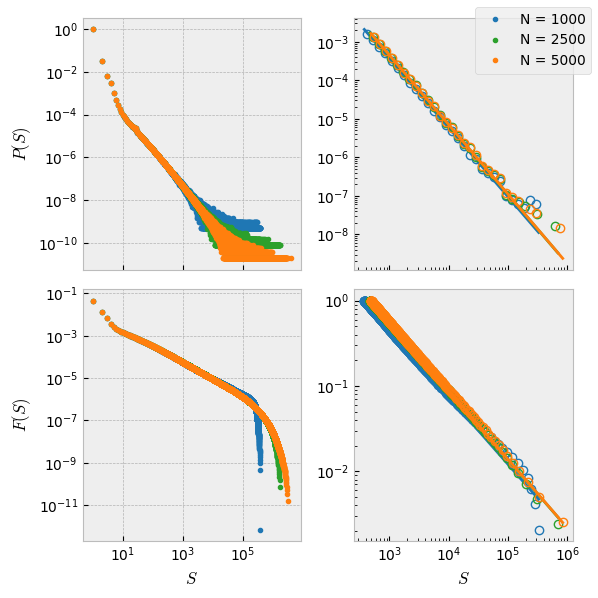

In [12]:
# Ensure the collected data corresponds to the same lambda but different sizes
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
ax = axes.ravel()

# Lists to store legend handles and labels
legend_labels = []
colors = ['#ff7f0e','#1f77b4', '#2ca02c']
# Plot PDFs and CCDFs for each size and the corresponding fit
for idx, (fit, sizes_uniq, pdf, ccdf, sizes_trunc, pdf_trunc, ccdf_trunc, label) in enumerate(zip(
    Fits, all_sizes_uniq, all_pdf, all_ccdf, all_sizes_trunc, all_pdf_trunc, all_ccdf_trunc, all_labels)):

    # Skip plotting for Size=500
    if 'Size = 500.00000' == label:
        continue

    # Select color based on index (C0, C1, C2, ...)
    color = colors[idx % len(colors)] 

    # Main PDF plot
    fit.plot_pdf(c=color, marker='o', fillstyle='none', ls='', alpha=1, ax=ax[1], label=f'PDF {label}')
    fit.power_law.plot_pdf(ls='-', lw=2, ax=ax[1], alpha=1, c=color, label=f'Power-law Fit {label}')
    ax[1].set(xscale='log', yscale='log' )
    ax[1].grid(False)

    # Main CCDF plot
    fit.plot_ccdf(c=color, marker='o', fillstyle='none', ls='', alpha=1, ax=ax[3], label=f'cCDF {label}')
    fit.power_law.plot_ccdf(ls='-', lw=2, ax=ax[3], alpha=1, c=color, label=f'Power-law Fit {label}')
    ax[3].set(xscale='log', yscale='log', xlabel='$S$')
    ax[3].grid(False)

    # Add handles and labels for the combined legend 
    legend_labels.append(f'N={label}')

    # Plot for untruncated PDF for each size
    ax[0].plot(sizes_uniq, pdf, '.', label=f'PDF {label}', color=color )
    ax[0].set(xscale='log', yscale='log',  ylabel='$P(S)$')

    # Plot for untruncated CCDF for each size
    ax[2].plot(sizes_uniq, ccdf, '.', label=f'CCDF {label}', color=color )
    ax[2].set(xscale='log', yscale='log', xlabel='$S$', ylabel='$F(S)$')

 
# Remove x-axis tick labels from the top-right plot (ax[1])
ax[1].set_xticklabels([])

# Remove y-axis tick labels from the top-left plot (ax[0])
ax[0].set_xticklabels([])

# Create a single legend for all plots
fig.legend(labels=["N ="+legend[8:13] for legend in legend_labels], loc='upper right') 

plt.tight_layout() 
plt.show()   

# FIG. 16: 

**Dataset Explanation:**

- **lambda:**  
  The control parameter value, varying in the range $0.8 < \lambda < 0.9$.

- **bootstrap-p-r:**  
  The bootstrap-based goodness-of-fit (GOF) $p$-value, denoted as $p_{\mathrm{gf}}$. This value quantifies the plausibility of a power-law model for the cluster size distribution; higher values (e.g. $p_{\mathrm{gf}} > 0.1$) indicate that the model is a plausible fit.

- **p (pl vs logn), R (pl vs logn):**  
  The $p$-value and log-likelihood ratio statistic for comparing a power-law model to a logarithmic model.

- **p (pl vs strexp), R (pl vs strexp):**  
  The $p$-value and log-likelihood ratio statistic for comparing a power-law model to a stretched-exponential model.

- **p (pl vs exp), R (pl vs exp):**  
  The $p$-value and log-likelihood ratio statistic for comparing a power-law model to a pure exponential model.

- **p (pl vs pltrc), R (pl vs pltrc):**  
  The $p$-value and log-likelihood ratio statistic for comparing a power-law model to a truncated power-law model.

**Plot Details:**

- **Main Plot:**  
  The main axes display the values of $p_{\mathrm{gf}}$ (the bootstrap goodness-of-fit $p$-value) versus $\lambda$. Data points are marked with circles:
  - Empty circles indicate points where the power-law model is not plausible (i.e. $p_{\mathrm{gf}} < 0.1$).
  - Filled circles indicate points where $p_{\mathrm{gf}} > 0.1$, meaning that the power-law hypothesis is favored.
  
- **Critical Lines:**  
  Vertical dashed lines are drawn at $\lambda_1 = 0.8605$ and $\lambda_2 = 0.875$, which are the critical points near which high $p_{\mathrm{gf}}$ values (and thus plausible power-law behavior) are observed.
  
- **Inset Plot:**  
  An inset zooms in on the $\lambda$-region near the critical points (approximately $0.858 < \lambda < 0.88$) to highlight the peaks of $p_{\mathrm{gf}}$.

**Key Observations:**

- The plot reveals clear peaks of high $p_{\mathrm{gf}}$ (above the threshold $p_{th} = 0.1$) near $\lambda_P$ and $\lambda_A$, indicating that the power-law model is plausible only near these critical points.
- Data points that pass the GOF test ($p_{\mathrm{gf}} > 0.1$) are distinct from those that fail.
- The inset further emphasizes the high $p_{\mathrm{gf}}$ values close to $\lambda_P$ and $\lambda_A$, even though some of these points may fail the log-likelihood ratio test.
- Overall, the results suggest that, in the logistic GOL, the power-law model is a plausible description of the cluster size distribution only near the critical points.

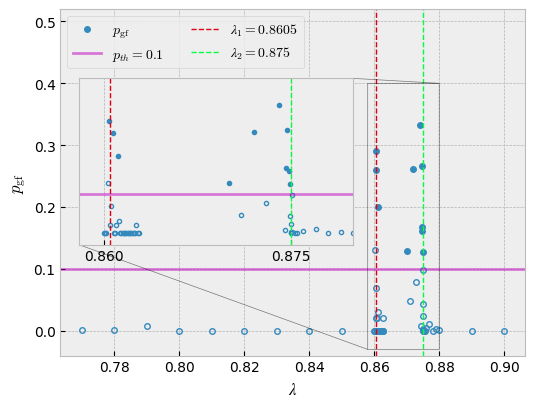

In [12]:
df_plot = pd.read_csv(Folder / "Fig16_data.csv")

pass_gof = df_plot['bootstrap-p-r'].values > 0.1
fail_lr_logn = (df_plot['p (pl vs logn)'].values < 0.05) & (df_plot['R (pl vs logn)'].values < 0)
fail_lr_strexp = (df_plot['p (pl vs strexp)'].values < 0.05) & (df_plot['R (pl vs strexp)'].values < 0)
fail_lr_exp = (df_plot['p (pl vs exp)'].values < 0.05) & (df_plot['R (pl vs exp)'].values < 0)
pass_lr_pltrc = (df_plot['p (pl vs pltrc)'].values < 0.05) & (df_plot['R (pl vs pltrc)'].values < 0)

mask_temp = pass_gof & ~fail_lr_logn & ~fail_lr_strexp & ~fail_lr_exp
pltrc_mask = mask_temp & pass_lr_pltrc
pl_mask = mask_temp & ~pltrc_mask



fig, ax = plt.subplots(figsize=(6, 4.5))
pass_idx = pl_mask | pltrc_mask; fail_idx = ~pass_idx

# Main plot
ax.plot(df_plot['lambda'][fail_idx], df_plot['bootstrap-p-r'][fail_idx],
         'o', c='C0', mfc='none', markersize=4, alpha=1)
ax.plot(df_plot['lambda'][pass_idx], df_plot['bootstrap-p-r'][pass_idx],
         'o', c='C0', markersize=4, label=r'$p_{\mathrm{gf}}$', alpha=1.)

ax.set(xlabel=r'$λ$', ylabel=r'$p_{\mathrm{gf}}$', ylim=(-0.04, 0.52))
ax.axhline(0.1, ls='-', label=r'$p_{th}=0.1$', alpha=0.5, c='m')
ax.axvline(0.8605, ls='--', lw=1 , label=r'$λ_1=0.8605$', alpha=1, c='#DE0014')
ax.axvline(0.875, ls='--', lw=1 , label=r'$λ_2=0.875$', alpha=1, c='#00FF40')
 
# Inset plot
axins = ax.inset_axes([0.04, 0.32, 0.59, 0.48],
                       xlim=(0.858, 0.88 ), ylim=(-0.03, 0.4), xticks=[0.86, 0.875], yticks=[])
axins.plot(df_plot['lambda'][fail_idx], df_plot['bootstrap-p-r'][fail_idx],
         'o', c='C0', mfc='none', markersize=3, alpha=1)
axins.plot(df_plot['lambda'][pass_idx], df_plot['bootstrap-p-r'][pass_idx],
         'o', c='C0', markersize=3, alpha=1)
axins.axvline(0.8605, ls='--', lw=1, alpha=1, c='#DE0014')
axins.axvline(0.875 , ls='--', lw=1, alpha=1, c='#00FF40')
axins.axhline(0.1, ls='-', alpha=0.5, c='m', label=r'$p=0.1$')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.legend(loc='upper left', ncol=2)
plt.show()

### Table II

In [44]:
df_plot = pd.read_csv(Folder / "Fig16_data.csv")
ilocs = df_plot['lambda'].round(6).searchsorted([0.8605, 0.875])
df_plot.iloc[ilocs][['bootstrap-p-u', 'R (pl vs logn)', 'p (pl vs logn)',
       'R (pl vs strexp)', 'p (pl vs strexp)', 'R (pl vs exp)',
       'p (pl vs exp)', 'R (pl vs pltrc)', 'p (pl vs pltrc)']]

,bootstrap-p-u,R (pl vs logn),p (pl vs logn),R (pl vs strexp),p (pl vs strexp),R (pl vs exp),p (pl vs exp),R (pl vs pltrc),p (pl vs pltrc)
14,1.0000,-0.303725,0.624743,2.154721,0.419316,681.258229,2.763514e-13,-1.226970,0.117230
50,0.9624,-0.413470,0.541381,-0.313082,0.798707,27.630720,4.701998e-03,-0.840841,0.194701
